# Разработка модели по уменьшению оттока сотрудников крупной компании "Х"

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам помогает машинное обучение, с помощью которого получается быстрее и точнее отвечать на вопросы бизнеса.

Крупная компания "Х" предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Наши задачи**
У нас будет несколько задач. 
Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных для первой задачи**

Для первой задачи заказчик предоставил данные с признаками:
 - id — уникальный идентификатор сотрудника;
 - dept — отдел, в котором работает сотрудник;
 - level — уровень занимаемой должности;
 - workload — уровень загруженности сотрудника;
 - employment_years — длительность работы в компании (в годах);
 - last_year_promo — показывает, было ли повышение за последний год;
 - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
 - salary — ежемесячная зарплата сотрудника;
 - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**План работы для достижения первой задачи будет таким:**

 1. Загрузка данных
 2. Предобработка данных
 3. Исследовательский анализ данных
 4. Подготовка данных
 5. Обучение моделей
 6. Выводы
 
**Описание данных для второй задачи**

Для этой задачи мы будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

**План работы для достижения второй задачи будет таким:**

 1. Загрузка данных
 2. Предобработка данных
 3. Исследовательский анализ данных
 4. Добавление нового входного признака
 5. Подготовка данных
 6. Обучение моделей
 7. Выводы
 
И в конце общие выводы по итогам выполнения двух задач.

Прежде чем загружать датасеты, нужно провести импорт необходимых библиотек.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
import shap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

RANDOM_STATE = 42

Кроме того, напишем функции, которые пригодятся нам в дальнейшей работе.

In [2]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def information(df):
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())

In [3]:
# Функция создает для списка столбцов два графика - гистограмму и ящик с усами.
def todoplot(df):
    for i in col:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

In [4]:
# Для оценки качества моделей напишем функцию, 
# которая будет вычислять метрику SMAPE (симметричное среднее абсолютное процентное отклонение).
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

In [5]:
# Функция создает для списка одинаковых столбцов из двух датасетов две круговых диаграммы.
def todopie(df,df1,title,ylabel):
    for i in cols:
        fig, axes = plt.subplots(1, 2, figsize=(15,10))
        t1=df.pivot_table(index=i, values='id', aggfunc='count')
        t2=df1.loc[df1[i] != ' '].pivot_table(index=i, values='id', aggfunc='count')
        labels=t1.index.unique()
        axes[0].pie(t1['id'], autopct='%1.0f%%', labels=labels)
        axes[0].set(ylabel=ylabel, title=title);
        axes[1].pie(t2['id'], autopct='%1.0f%%', labels=labels);
        axes[1].set(ylabel=ylabel, title=title);
        plt.legend(bbox_to_anchor=(1, 0.6));
        plt.show()

In [6]:
# Функция для создания пайплайна.
# Cоздадим пайпы для подготовки данных: для признаков, которые будет кодировать OneHotEncoder, 
# для признаков, которые будем кодировать OrdinalEncoder (включим в пайпы обработку пропусков с помощью SimpleImputer). 
# Затем соединим полученные пайпы в data_preprocessor, туда же добавим масштабирование количественных признаков.
def pipe(ohe_columns, ord_columns, num_columns):
    global pipe_final
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore')
            )
        ]
    ) 

    ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

## 1 Задача 1

### 1.1 Загрузка данных

#### 1.1.1
Сначала попытаемся открыть файлы с датасетами

In [7]:
try:
    train = pd.read_csv('/???/train_job_satisfaction_rate.csv')
except:
    train = pd.read_csv('https://???/train_job_satisfaction_rate.csv')
try:
    X_test = pd.read_csv('/???/test_features.csv')
except:
    X_test = pd.read_csv('https://???/test_features.csv')
try:
    y_test = pd.read_csv('/???/test_target_job_satisfaction_rate.csv')
except:
    y_test = pd.read_csv('https://???/test_target_job_satisfaction_rate.csv')

#### 1.1.2
Посмотрим первые строки датасетов

In [8]:
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [10]:
y_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Теперь посмотрим общую информацию о датасетах

In [11]:
information(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Количество дубликатов: 0 

Количество пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo    

In [12]:
information(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Количество дубликатов: 0 

Количество пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary        

In [13]:
information(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

Количество дубликатов: 0 

Количество пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64


***Вывод:*** Общая информация показывает, что в тренировочной выборке имеется 4000 строк, есть пропущенные значения в колонках с отделом и занимаемой должностью, дублей нет, все форматы данных соответствуют данным. В тестовой выборке с входными данными имеется 2000 строк, так же есть пропущенные значения в колонках с отделом и занимаемой должностью, дублей нет, все форматы данных соответствуют данным. В тестовый выборке с целевым признаком строк так же 2000, дублей нет, пропусков нет, форматы данных соответствуют данным. Пропусками займемся на этапе подготовки данных в пайплайне.

### 1.2 Предобработка данных

#### 1.2.1
Так как дубликатов в данных нет, а все форматы соответствуют данным, то займемся поиском ошибок в данных. Для этого изучим уникальные значения во всех колонках типа object.

In [14]:
train['dept'].sort_values().unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', nan],
      dtype=object)

In [15]:
X_test['dept'].sort_values().unique()

array([' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology', nan],
      dtype=object)

In [16]:
train['level'].sort_values().unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [17]:
X_test['level'].sort_values().unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
train['workload'].sort_values().unique()

array(['high', 'low', 'medium'], dtype=object)

In [19]:
X_test['workload'].sort_values().unique()

array([' ', 'high', 'low', 'medium'], dtype=object)

In [20]:
train['last_year_promo'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [21]:
X_test['last_year_promo'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [22]:
train['last_year_violations'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [23]:
X_test['last_year_violations'].sort_values().unique()

array(['no', 'yes'], dtype=object)

#### 1.2.2
Теперь осталось поискать аномальные значения в количественных признаках. Для этого воспользуемся функцией, которая строит гистограмму и "ящик с усами" для всех признаков.

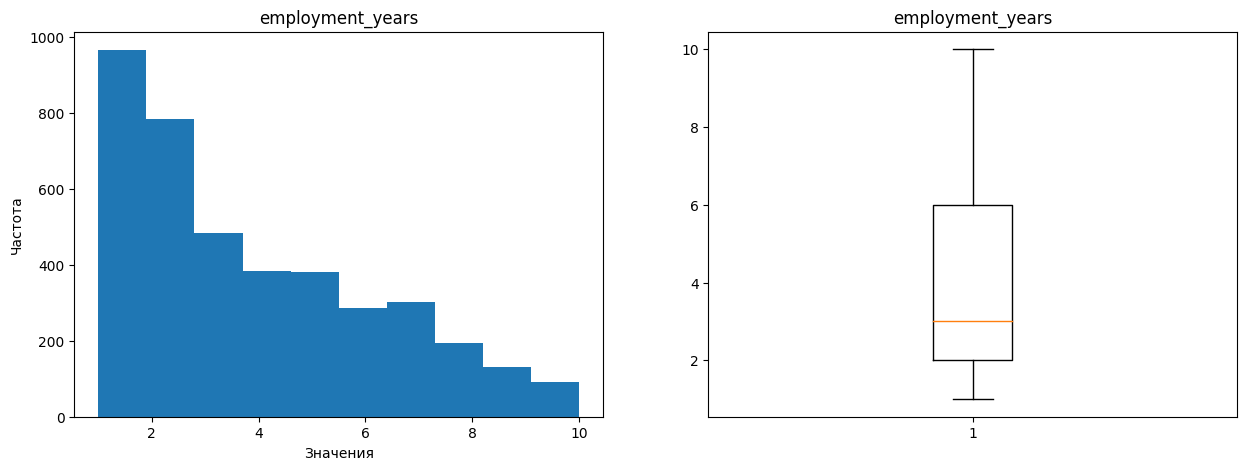

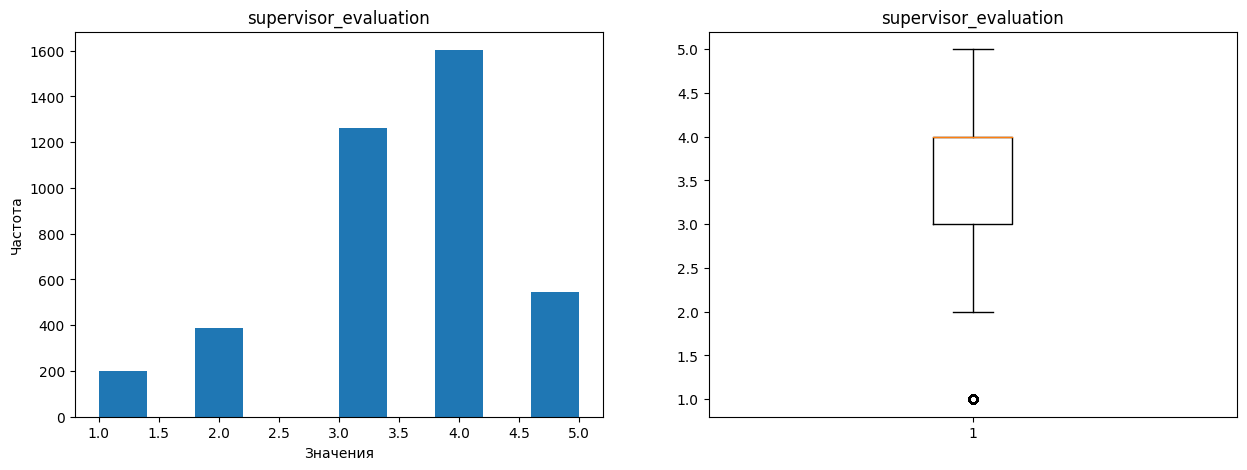

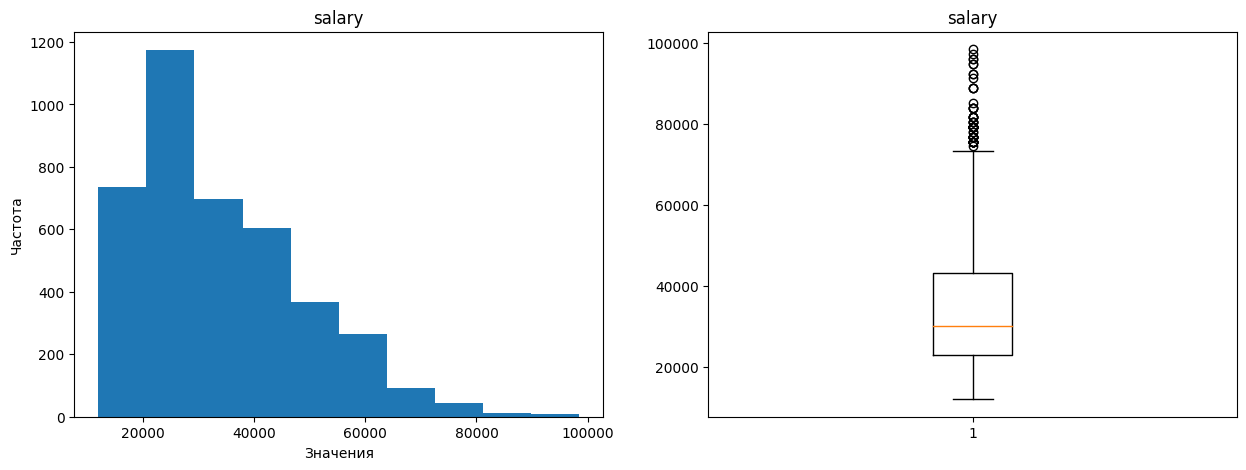

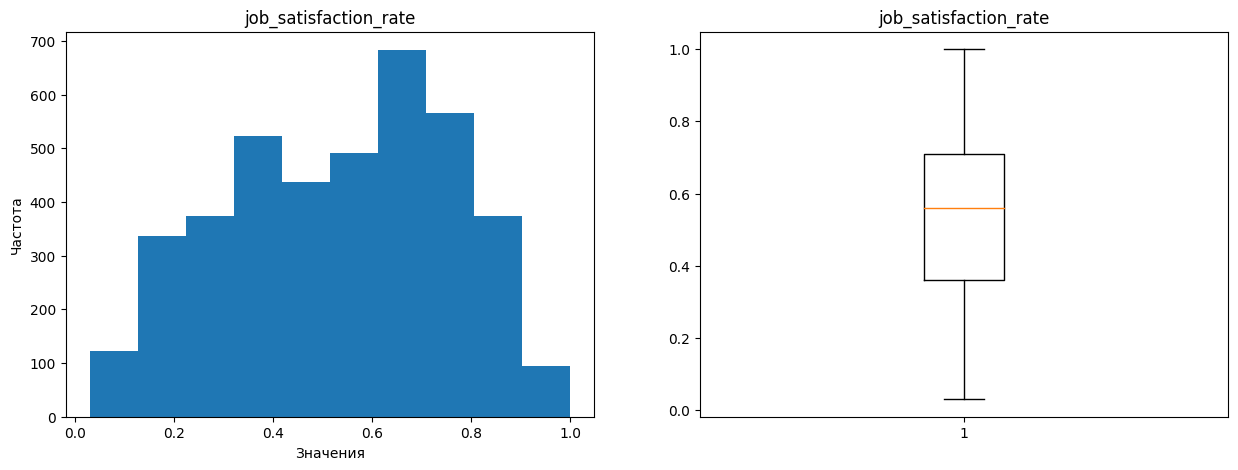

In [24]:
col=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
todoplot(train)

Отрицательных и аномальных значений в тренировочной выборке не выявлено. На диаграммах "ящик с усами" в колонках supervisor_evaluation и salary имеются выбросы, но мы их трогать не будем. Интересная картина в колонках employment_years и supervisor_evaluation, там всего 10 и 5 вариантов числовых значений соответственно, так что очевидно, что это дискретные признаки, но подробным анализом признаков мы займемся на следующем этапе. Итог по всем колонкам: данные выглядят достоверно.

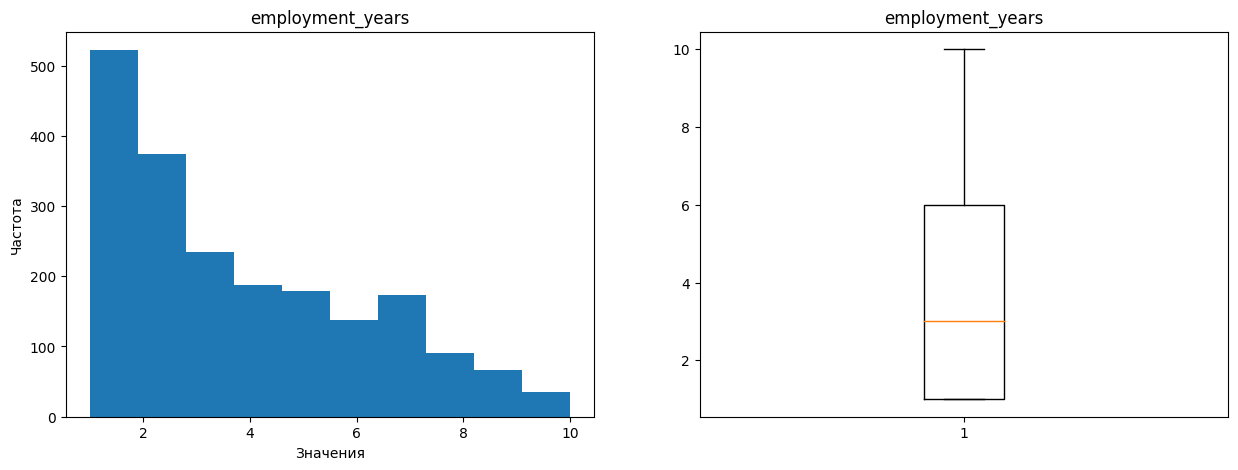

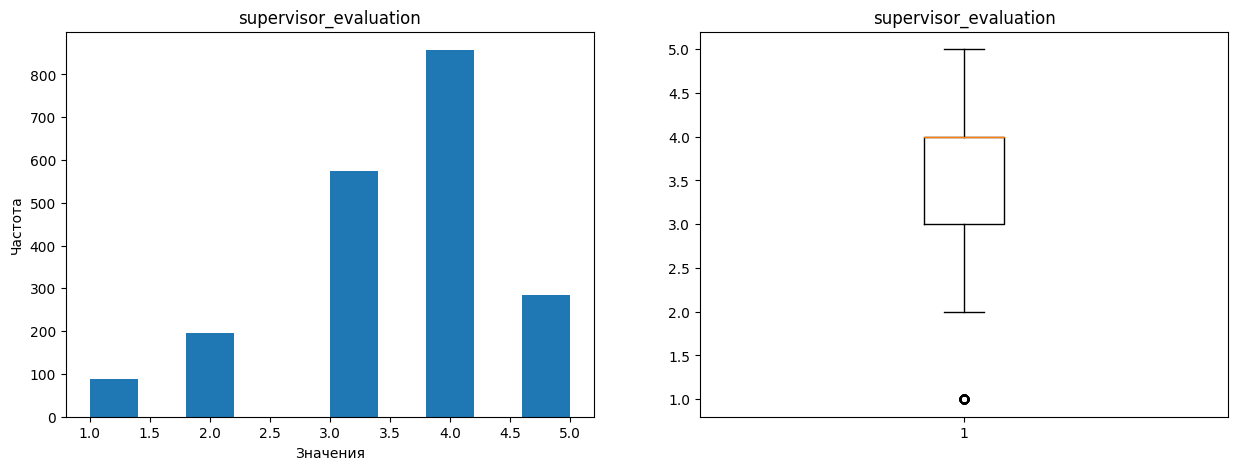

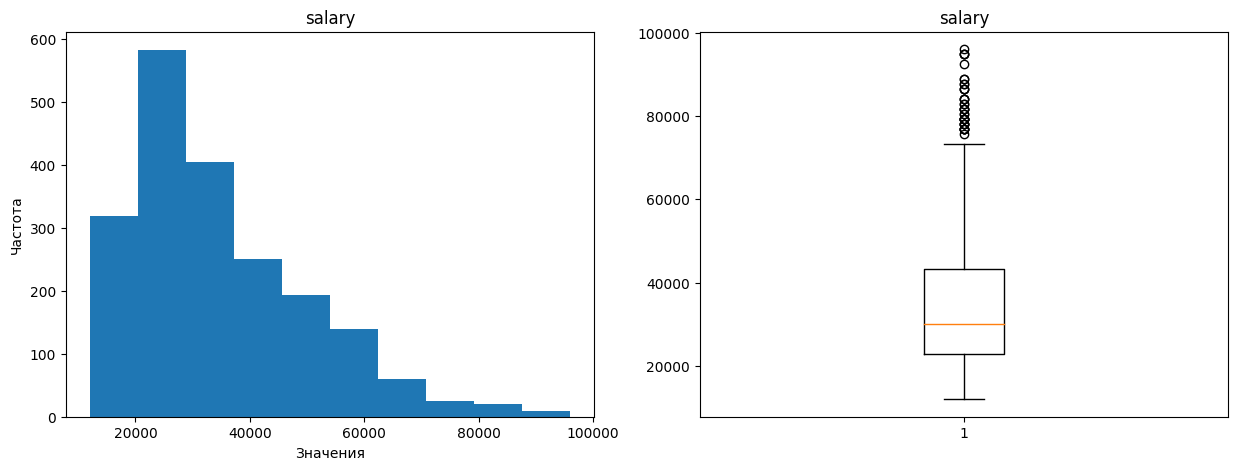

In [25]:
col=['employment_years', 'supervisor_evaluation', 'salary']
todoplot(X_test)

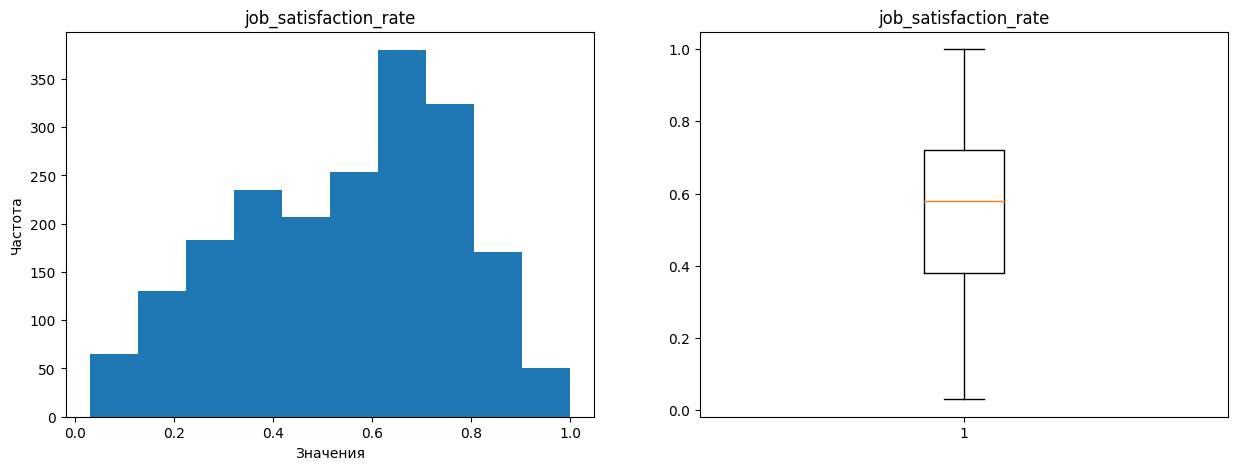

In [26]:
col=['job_satisfaction_rate']
todoplot(y_test)

В тестовой выборке картина аналогичная тренировочной. Отрицательных и аномальных значений нет, данные выглядят достоверно.

***Вывод:*** На этом предобработка данных завершена. На этом этапе мы проверили данные на ошибки в категориальных признаках. Нашли пустые значения в двух колонках тестовой выборки и заменили их на NaN. Проверили количественных данные на достоверность и не нашли отрицательных и аномальных значений, таким образом можно перейти к анализу данных.

### 1.3 Исследовательский анализ данных

#### 1.3.1
Проведем статистический анализ всех признаков. Начнем с количественных признаков.

In [27]:
train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [28]:
X_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [29]:
y_test.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Уже по этим таблицам мы видим, что данные в тренировочной и тестовой выборках распределены достаточно равномерно. Средние, медианные, максимальные и минимальные значения в них примерно одинаковые. А значит модели будет легче предсказывать удовлетворенность на тестовой выборке.

Теперь еще раз построим гистограммы по непрерывным количественным признакам, но проанализируем уже более прицельно.

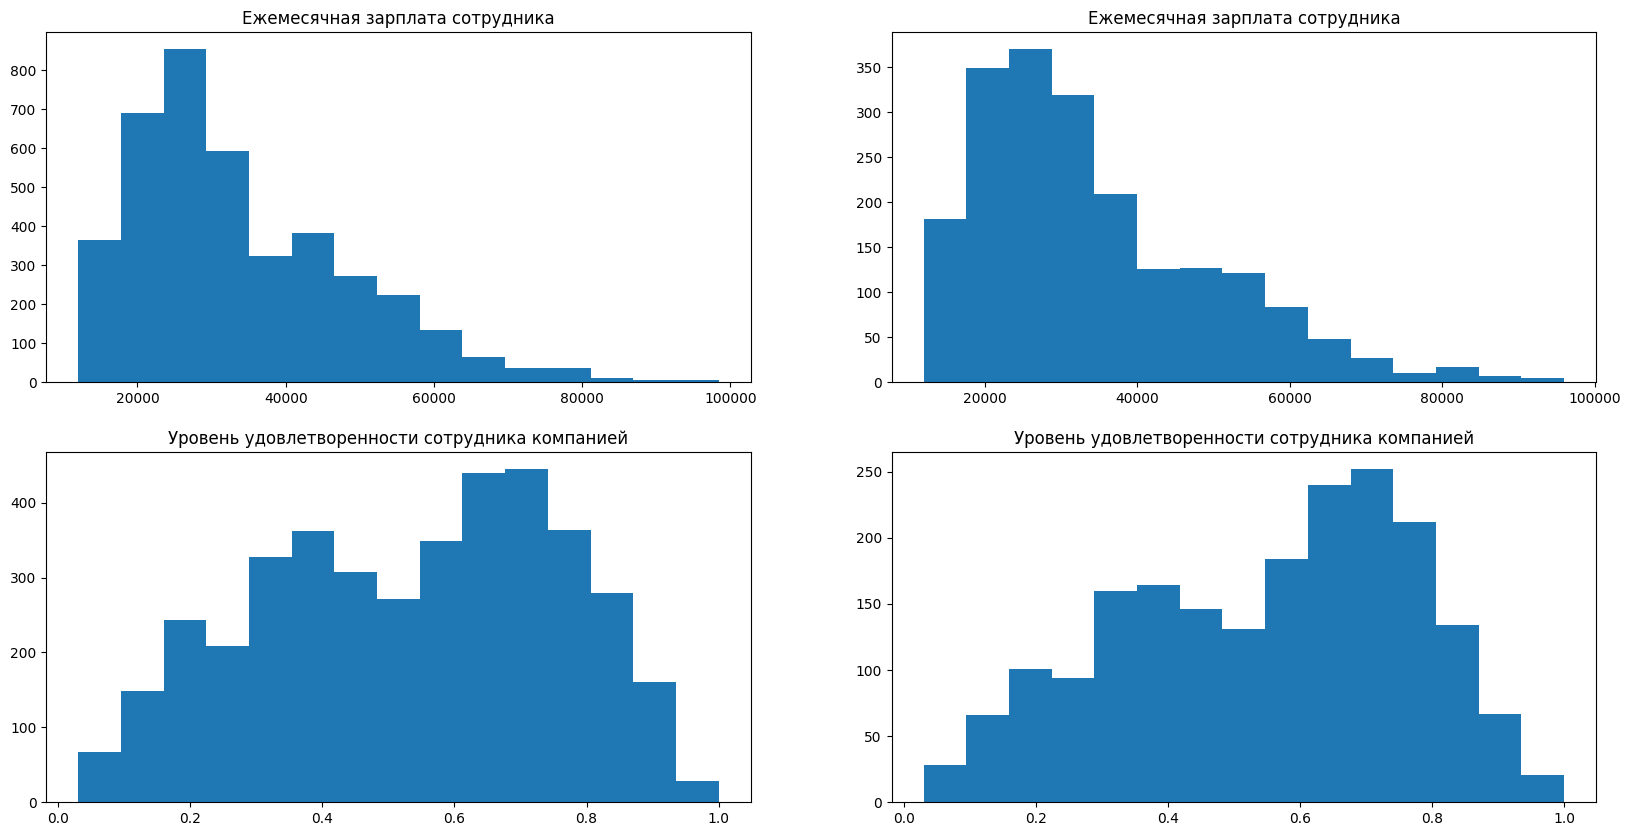

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10));
axs[0, 0].hist(train['salary'], bins=15);
axs[0, 0].set_title('Ежемесячная зарплата сотрудника');
axs[0, 1].hist(X_test['salary'], bins=15);
axs[0, 1].set_title('Ежемесячная зарплата сотрудника');
axs[1, 0].hist(train['job_satisfaction_rate'], bins=15);
axs[1, 0].set_title('Уровень удовлетворенности сотрудника компанией');
axs[1, 1].hist(y_test['job_satisfaction_rate'], bins=15);
axs[1, 1].set_title('Уровень удовлетворенности сотрудника компанией');

Непрерывные количественные признаки распределены не совсем равномерно. В ежемесячной зарплате сотрудников имеется сдвиг влево, а в уровне удовлетворенности сотрудников - сдвиг вправо. В тренировочной и тестовой выборках картина примерно одинаковая. Явно видно, что масштаб у данных сильно отличается, поэтому для подготовки данных придется использовать масштабирование.

По дискретным количественным признакам построим столбиковые диаграммы.

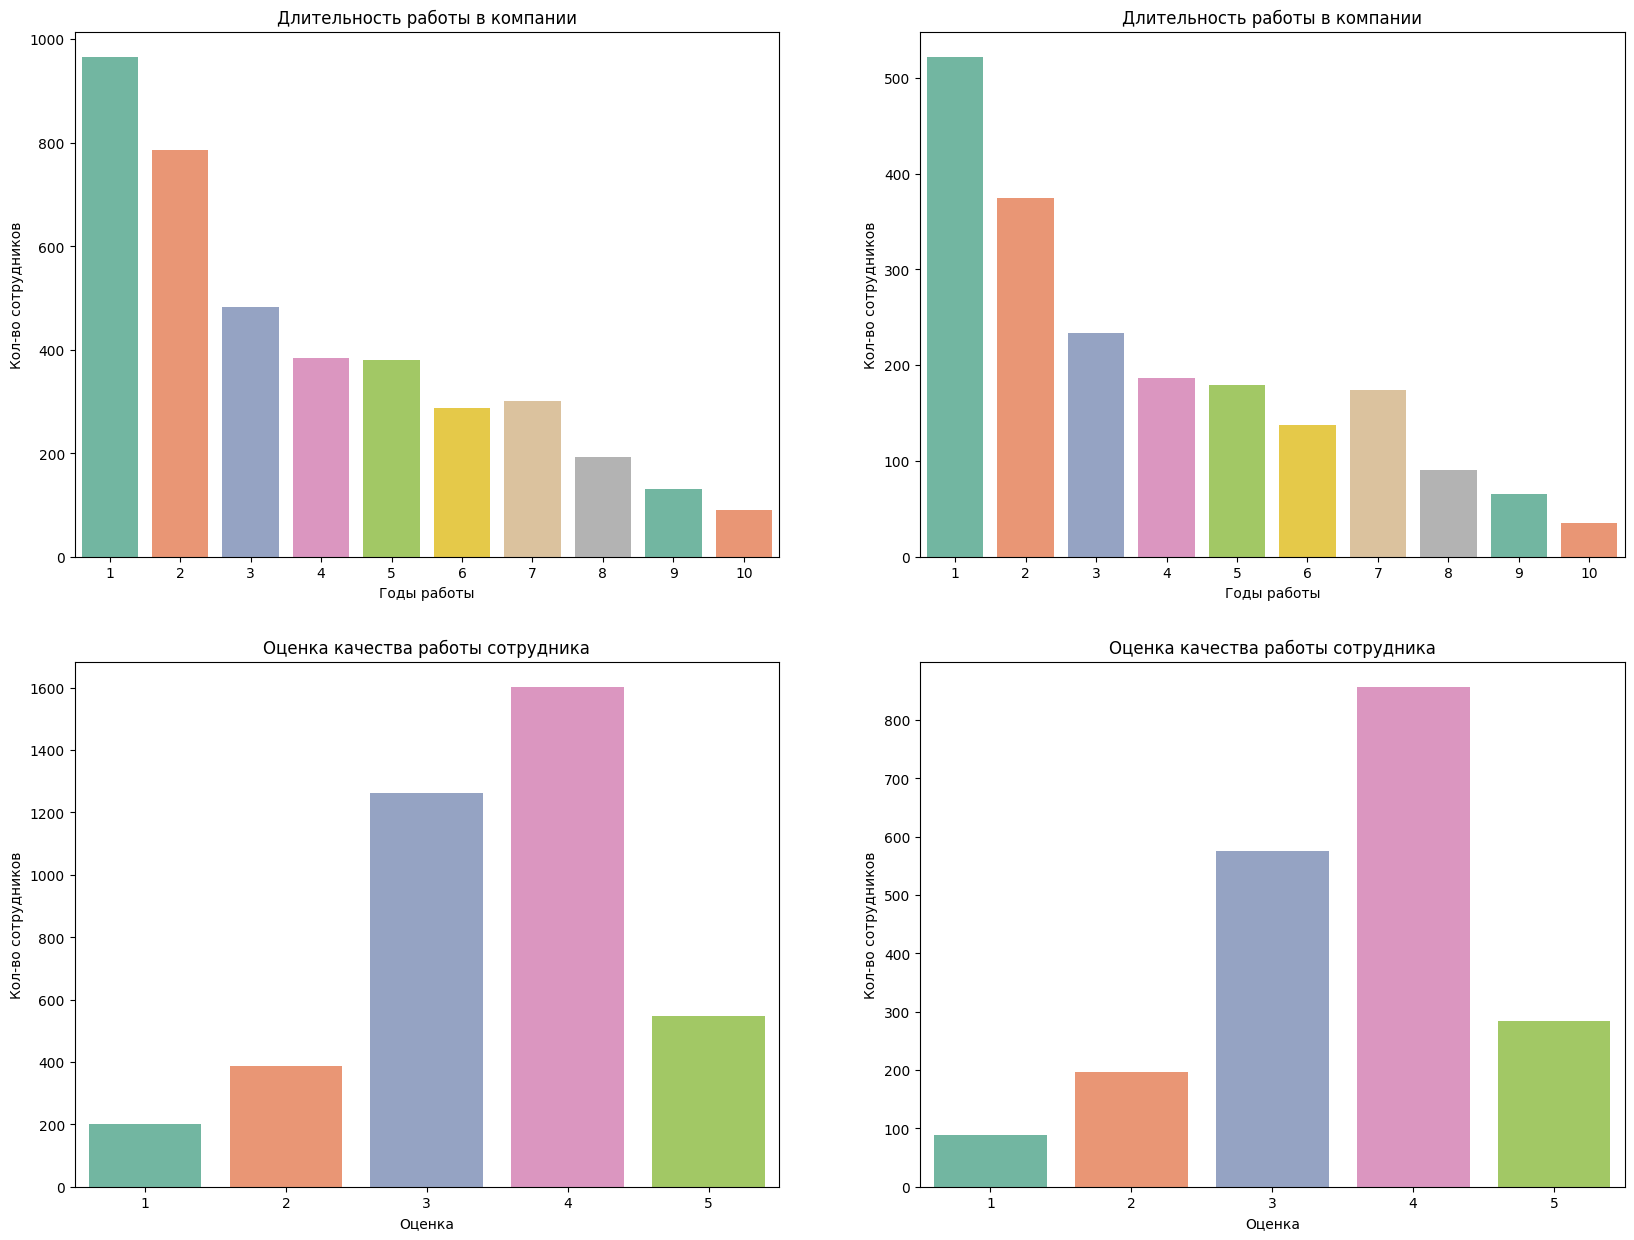

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.countplot(x ='employment_years', data = train, 
              palette = "Set2", ax=axes[0,0]).set(title='Длительность работы в компании', 
                                                    xlabel='Годы работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', data = X_test, 
              palette = "Set2", ax=axes[0,1]).set(title='Длительность работы в компании', 
                                                    xlabel='Годы работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = train, 
              palette = "Set2", ax=axes[1,0]).set(title='Оценка качества работы сотрудника', 
                                                  xlabel='Оценка', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = X_test, 
              palette = "Set2", ax=axes[1,1]).set(title='Оценка качества работы сотрудника', 
                                                  xlabel='Оценка', ylabel='Кол-во сотрудников');

Преобладают сотрудники, которые работают в компании один год, видно, что чем больше лет в компании, тем меньше сотрудников. В оценках сотрудников преобладают оценки 3 и 4. Видно, что в тренировочной и тестовой выборках соотношения примерно одинаковые.

#### 1.3.2
Теперь перейдем к категориальным признакам. Построим круговые диаграммы по каждому признаку для тренировочной и тестовой выборок.

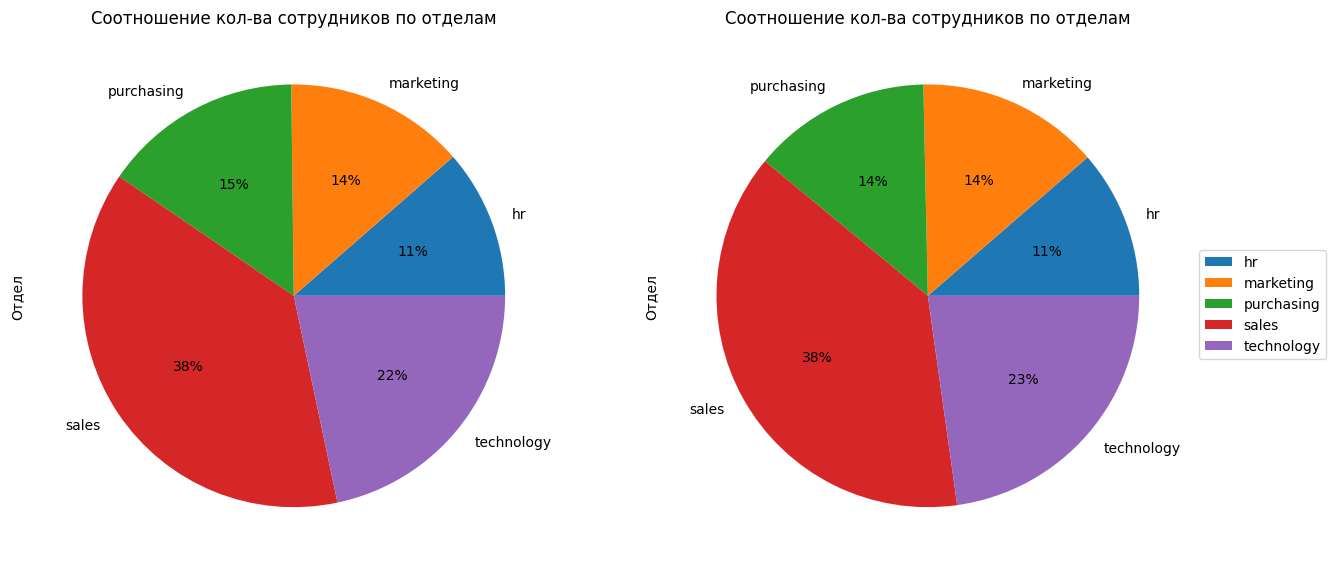

In [32]:
cols=['dept']
todopie(train,X_test,'Соотношение кол-ва сотрудников по отделам','Отдел')

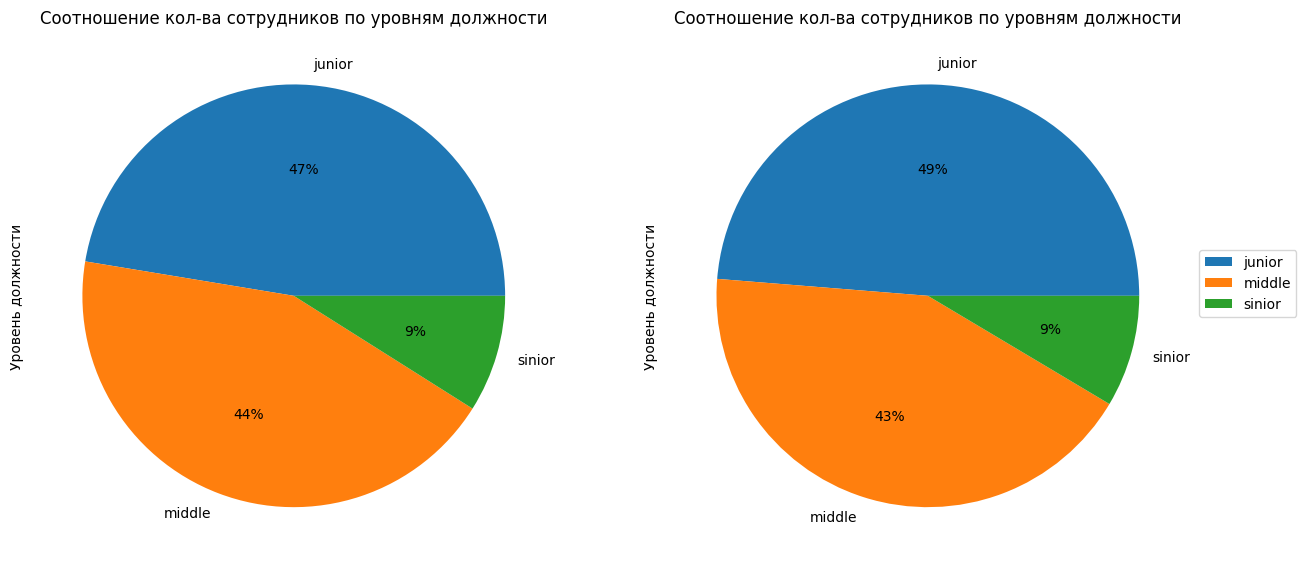

In [33]:
cols=['level']
todopie(train,X_test,'Соотношение кол-ва сотрудников по уровням должности','Уровень должности')

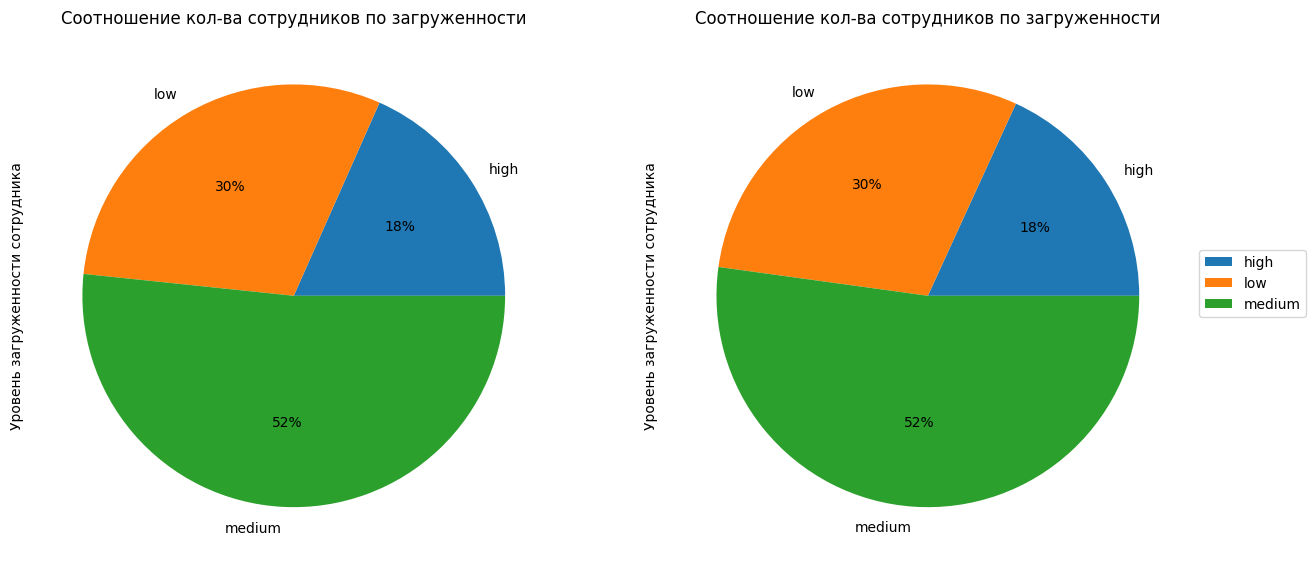

In [34]:
cols=['workload']
todopie(train,X_test,'Соотношение кол-ва сотрудников по загруженности','Уровень загруженности сотрудника')

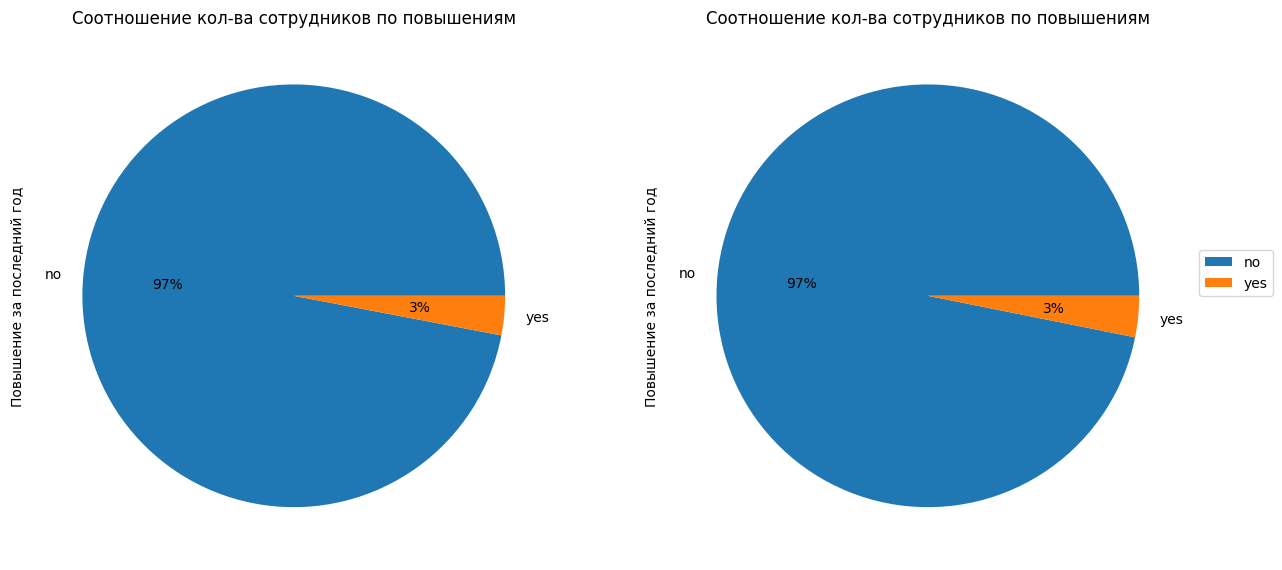

In [35]:
cols=['last_year_promo']
todopie(train,X_test,'Соотношение кол-ва сотрудников по повышениям','Повышение за последний год')

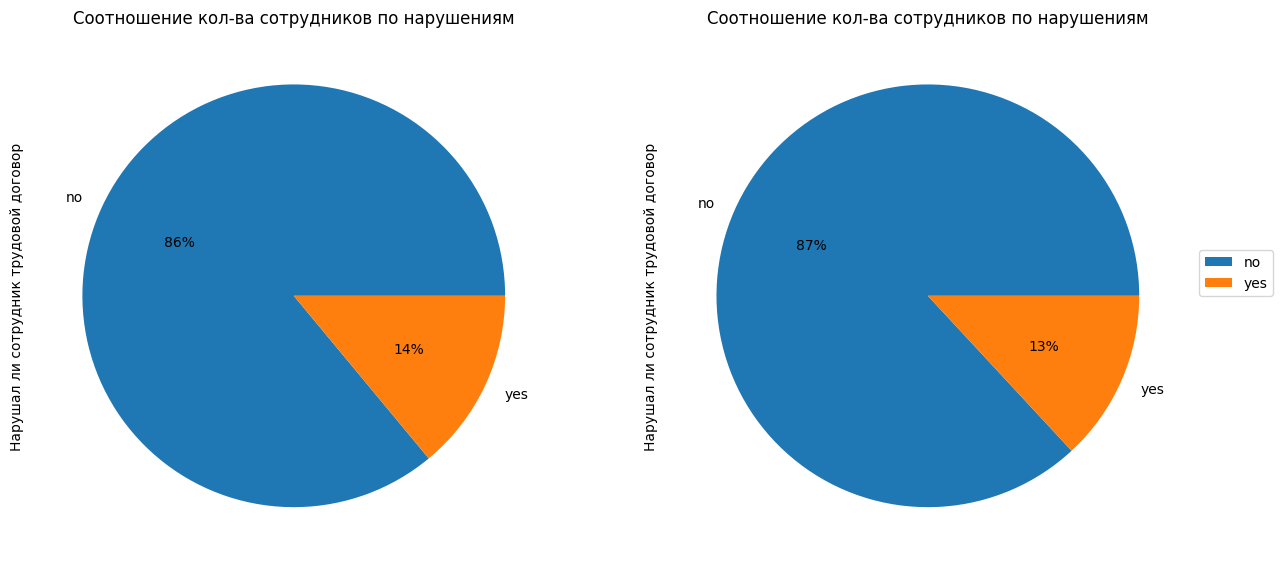

In [36]:
cols=['last_year_violations']
todopie(train,X_test,'Соотношение кол-ва сотрудников по нарушениям','Нарушал ли сотрудник трудовой договор')

Изучив диаграммы, мы видим, что среди сотрудников компании по отделам преобладают продажники, по уровню занимаемой должности - junior и middle, по загруженности больше всего сотрудников со средним уровнем загруженности. Повышение было только у 3% сотрудников, а нарушения трудового договора выявлены у 14% сотрудников. Распределение данных в тестовой и тренировочной выборках практически идентичное.

Для подготовки категориальных данных мы будем использовать кодирование, для признаков с нарушениями и повышениями можно использовать OneHotEncoder, для остальные OrdinalEncoder, причем надо учесть, что уровень должности и уровень загруженности это ранговые признаки.

#### 1.3.3
Осталось провести корреляционный анализ, чтобы выяснить, нет ли утечки целевого признака. Для этого используем модуль phik.

In [37]:
data=train.set_index('id')

In [38]:
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(data,interval_cols=interval_cols)

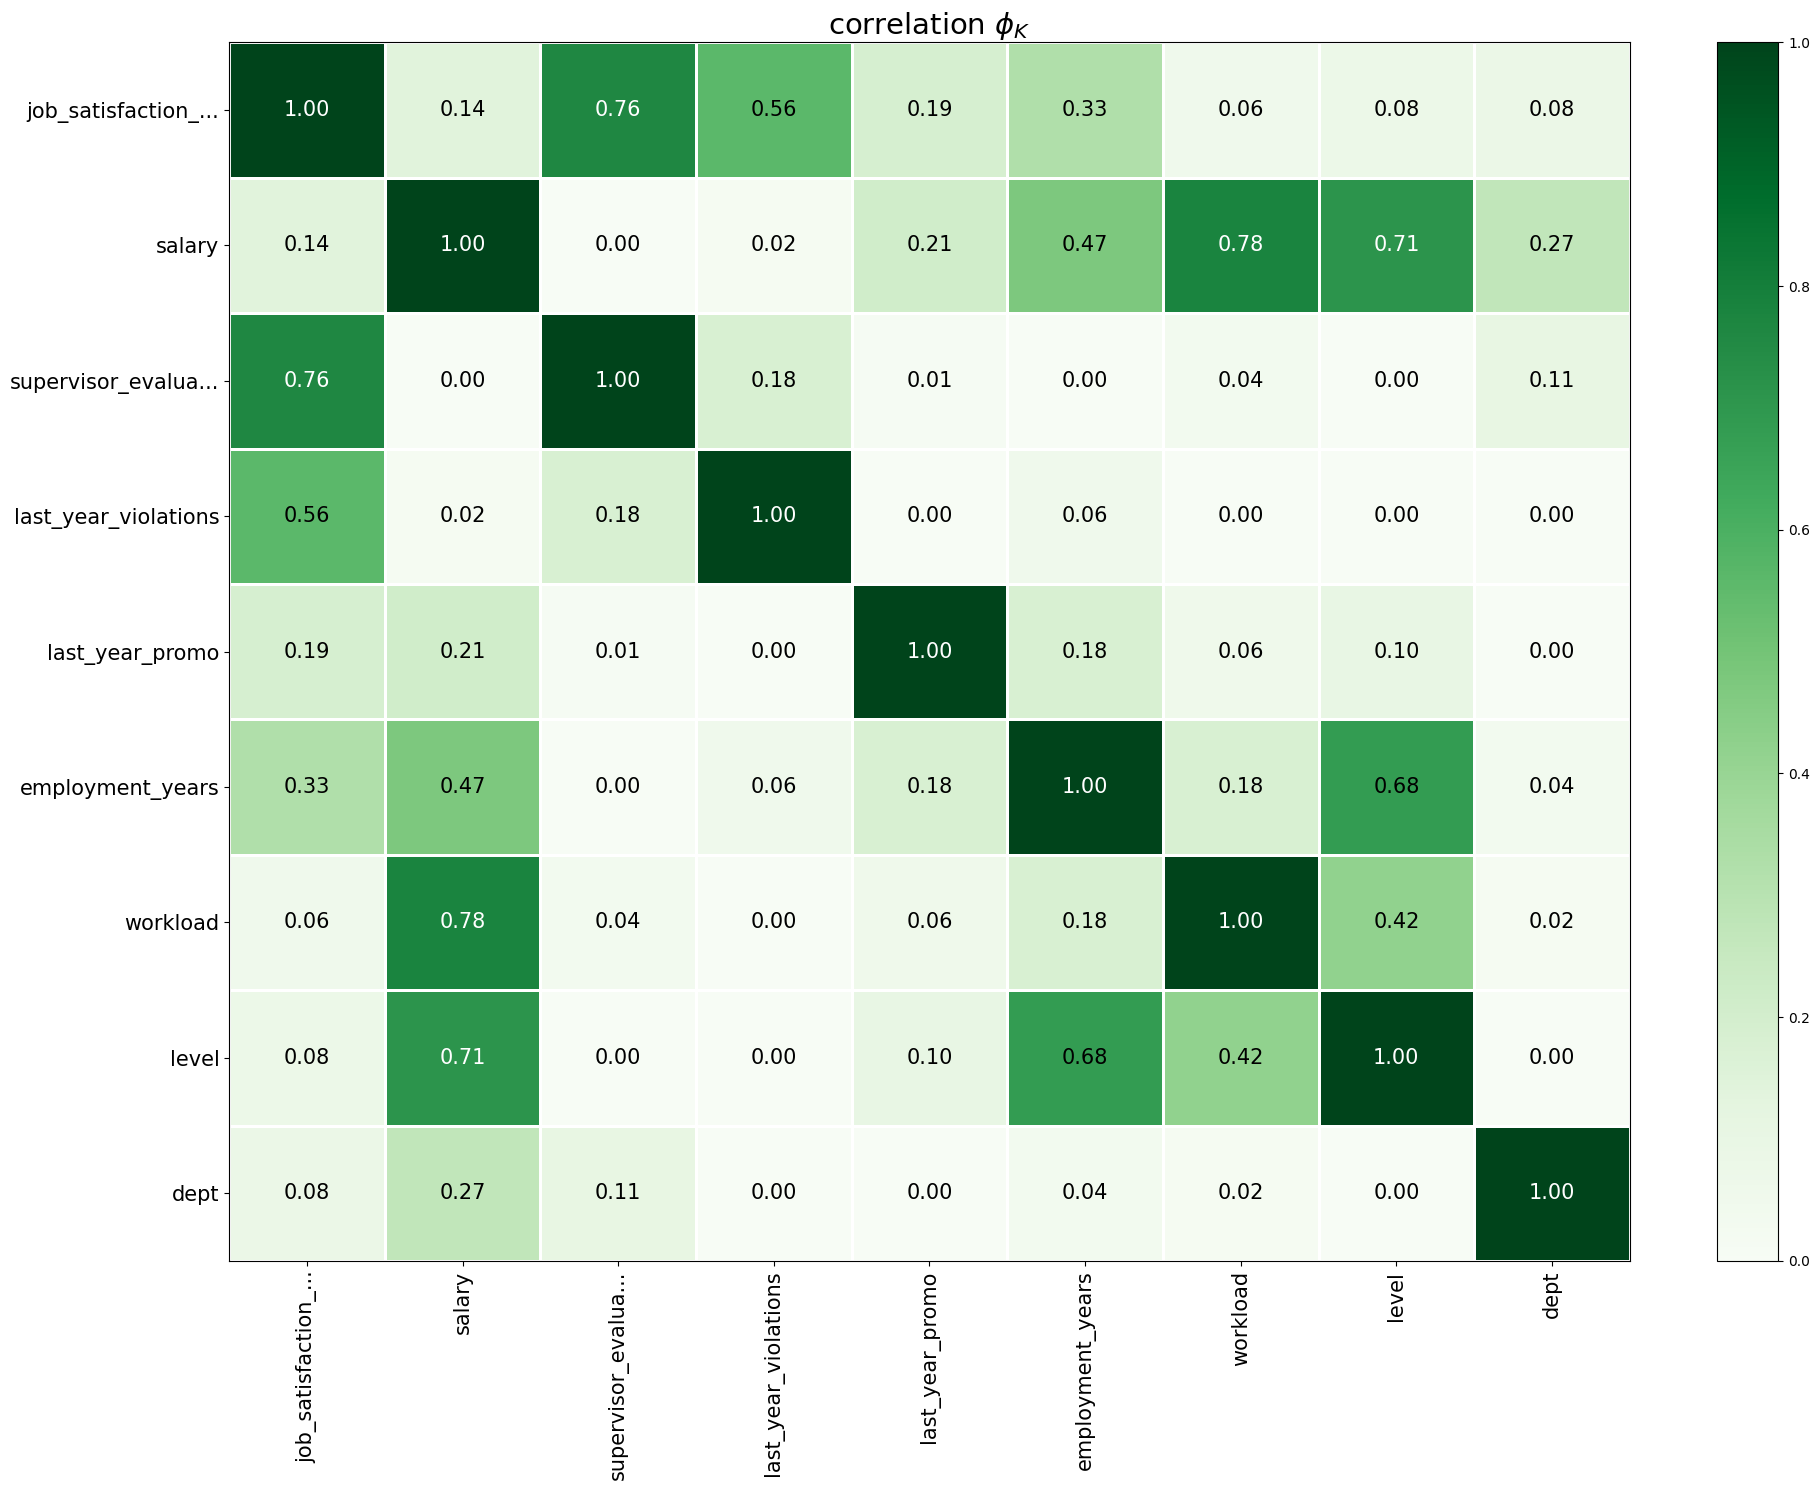

In [39]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Утечки целевого признака не обнаружено.

***Вывод:*** Таким образом, мы провели исследовательский анализ данных, посмотрели распределение данных во всех таблицах, по итогам анализа можно сказать, что данные выглядят достоверно, особых выбросов нет, при проведении корреляционного анализа утечки целевого признака не обнаружено. Перед обучением необходимо будет провести подготовку данных в пайплайне: масштабирование количественных признаков, кодирование категориальных признаков, обработку пропусков.

### 1.4 Подготовка данных

Перечислим особенности данных:
 - Два признака: Нарушения трудового договора и Повышение за последний год — нужно кодировать с помощью OneHotEncoder.
 - Три признака: Отдел, Уровень должности и Уровень загруженности — нужно кодировать с помощью OrdinalEncoder, причем два последних это ранговые признаки.
 - В признаках, закодированных этими методами, встречаются пропуски.
 - Целевой признак — Удовлетворённость сотрудника работой в компании.
 - Количественные признаки: Количество лет в компании, Оценка работодателя и Зарплата нужно масштабировать.

Сначала разделим тренировочную выборку на две: с целевым и без него. Но перед этим удалим из данных ненужный признак id и проверим, не появились ли дубликаты после этого.

In [40]:
train_temp = train.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp.duplicated().sum())

Количество дубликатов: 245


Удалим дубликаты. Такие данные в обучающей выборке не приносят дополнительной информации в модель, но создают необоснованный вес таким наблюдениям. Кроме того, увеличение объёма выборки, увеличивает расход вычислительных ресурсов и времени обучения.

In [41]:
train_temp = train_temp.drop_duplicates().reset_index(drop=True)

In [42]:
X_train = train_temp.drop(['job_satisfaction_rate'], axis=1)
y_train = train_temp['job_satisfaction_rate']

In [43]:
X_train.shape

(3755, 8)

Тестовую выборка наоборот сначала соединим, чтобы данные целевого признака шли в том же порядке, что и во входных признаках. Для этого соединим таблицы по id.

In [44]:
test = X_test.merge(y_test, on='id')

In [45]:
X_test_ = test.drop(['job_satisfaction_rate','id'], axis=1)
y_test_ = test['job_satisfaction_rate']
X_test_.shape

(2000, 8)

Теперь определим наши признаки и запустим функцию создания пайплайна.

In [46]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 

In [47]:
pipe(ohe_columns, ord_columns, num_columns)

***Вывод:*** На этом этапе мы провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна. И теперь мы готовы приступить к обучению моделей.

### 1.5 Обучение моделей

Так как целевой признак у нас непрерывный количественный, то для для обучения будем брать модели регрессии: модель линейной регрессии и дерево решений (для дерева решений используем перебор разных гиперпараметров). 

In [48]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 11),
        'models__max_features': range(5, 11)
    },
 
    {
        'models': [LinearRegression()]
    }
]

Создадим свою метрику SMAPE, используя функцию, написанную выше.

In [49]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Запустим обучение перебором, используя метод GridSearchCV.

In [50]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
                                                                         StandardScaler(),
                                                                         ['salary',
                                                                          'employment_years',
                                                                          'supervisor_evaluation'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(max_depth=10,
                                                           max_features=10,
                                                           random_state=42)],
                          'models__max_depth': range(5, 11),
                          'models__max_features': range(5, 11)},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

Теперь выберем лучшую модель и посмотрим ее метрику.

In [51]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10. 

Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику SMAPE.

In [52]:
y_pred_test = grid.best_estimator_.predict(X_test_)
smape_test = smape(y_test_, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 14.954152848649462


Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


Метрика получилась равной 14.95, что даже лучше, чем на тренировочной выборке, значит наша модель работает хорошо. 

Посмотрим, какие результаты выдавали другие обученные модели.

In [53]:
res = pd.DataFrame(grid.cv_results_)
res.mean_test_score = res.mean_test_score * -1
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.065366,0.006264,0.026711,0.006107,"DecisionTreeRegressor(max_depth=10, max_featur...",5,5,"{'models': DecisionTreeRegressor(max_depth=10,...",-21.746378,-22.359180,-22.960229,-22.616621,-32.150228,24.366527,3.912045,36
1,0.058117,0.012136,0.017927,0.002001,"DecisionTreeRegressor(max_depth=10, max_featur...",5,6,"{'models': DecisionTreeRegressor(max_depth=10,...",-21.513499,-19.408812,-24.235019,-21.051991,-21.543579,21.550580,1.551992,35
2,0.051501,0.004417,0.018065,0.001524,"DecisionTreeRegressor(max_depth=10, max_featur...",5,7,"{'models': DecisionTreeRegressor(max_depth=10,...",-21.267810,-19.441156,-21.834037,-21.532297,-21.274509,21.069962,0.840423,34
3,0.051801,0.005116,0.017500,0.001270,"DecisionTreeRegressor(max_depth=10, max_featur...",5,8,"{'models': DecisionTreeRegressor(max_depth=10,...",-20.381659,-20.321410,-22.042398,-20.983786,-20.133371,20.772525,0.695990,32
4,0.054968,0.005543,0.018644,0.001554,"DecisionTreeRegressor(max_depth=10, max_featur...",5,9,"{'models': DecisionTreeRegressor(max_depth=10,...",-21.141116,-19.978933,-21.748086,-20.996357,-20.481164,20.869131,0.600948,33
5,0.050174,0.003756,0.019245,0.002167,"DecisionTreeRegressor(max_depth=10, max_featur...",5,10,"{'models': DecisionTreeRegressor(max_depth=10,...",-20.040530,-19.348938,-21.162762,-20.355754,-20.219929,20.225583,0.582757,29
6,0.050078,0.002598,0.017630,0.001783,"DecisionTreeRegressor(max_depth=10, max_featur...",6,5,"{'models': DecisionTreeRegressor(max_depth=10,...",-20.657295,-20.020949,-20.156439,-21.244614,-20.252415,20.466342,0.443249,31
7,0.052475,0.003320,0.019501,0.002371,"DecisionTreeRegressor(max_depth=10, max_featur...",6,6,"{'models': DecisionTreeRegressor(max_depth=10,...",-20.767618,-20.073532,-20.835884,-19.951189,-20.195245,20.364693,0.365744,30
8,0.049917,0.003287,0.018275,0.001487,"DecisionTreeRegressor(max_depth=10, max_featur...",6,7,"{'models': DecisionTreeRegressor(max_depth=10,...",-19.811260,-18.089895,-19.951207,-20.502866,-20.321009,19.735247,0.859297,28
9,0.048780,0.002170,0.016573,0.000926,"DecisionTreeRegressor(max_depth=10, max_featur...",6,8,"{'models': DecisionTreeRegressor(max_depth=10,...",-19.735807,-18.952525,-19.768593,-20.156744,-19.337195,19.590173,0.411008,25


По таблице видно, что результаты разных моделей отличаются друг от друга, при увеличении глубины дерева решений увеличивается точность предсказаний. Результаты линейной регрессии хуже, чем у дерева решений.

### 1.6 Выводы

Мы выполнили первую поставленную перед нами задачу: построили модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Провели обучение моделей, выбрали лучшую на основе метрики SMAPE. Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10. После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.

Вероятно дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров.

## 2 Задача 2 

### 2.1 Загрузка данных

Пора переходить ко второй задаче. Для этого нужно загрузить данные с новым признаком. И посмотреть общую информацию.

In [54]:
try:
    train1 = pd.read_csv('/???/train_quit.csv')
except:
    train1 = pd.read_csv('https://???/train_quit.csv')
try:
    y_test1 = pd.read_csv('/???/test_target_quit.csv')
except:
    y_test1 = pd.read_csv('https://???/test_target_quit.csv')

In [55]:
X_test1 = X_test

In [56]:
train1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [57]:
y_test1.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [58]:
information(train1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Количество дубликатов: 0 

Количество пропусков:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violat

In [59]:
information(y_test1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Количество дубликатов: 0 

Количество пропусков:
 id      0
quit    0
dtype: int64


***Вывод***: В новых датасетах пропусков и дублей нет. В тренировочной выборке всё так же 4000 строк, в тестовой 2000.

### 2.2 Предобработка данных

Нужно убедиться, что в новых данных нет ошибок и аномальных значений.

In [60]:
train1['dept'].sort_values().unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology'],
      dtype=object)

In [61]:
train1['level'].sort_values().unique()

array(['junior', 'middle', 'sinior'], dtype=object)

In [62]:
train1['last_year_promo'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [63]:
train1['workload'].sort_values().unique()

array(['high', 'low', 'medium'], dtype=object)

In [64]:
train1['last_year_violations'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [65]:
train1['quit'].sort_values().unique()

array(['no', 'yes'], dtype=object)

In [66]:
y_test1['quit'].sort_values().unique()

array(['no', 'yes'], dtype=object)

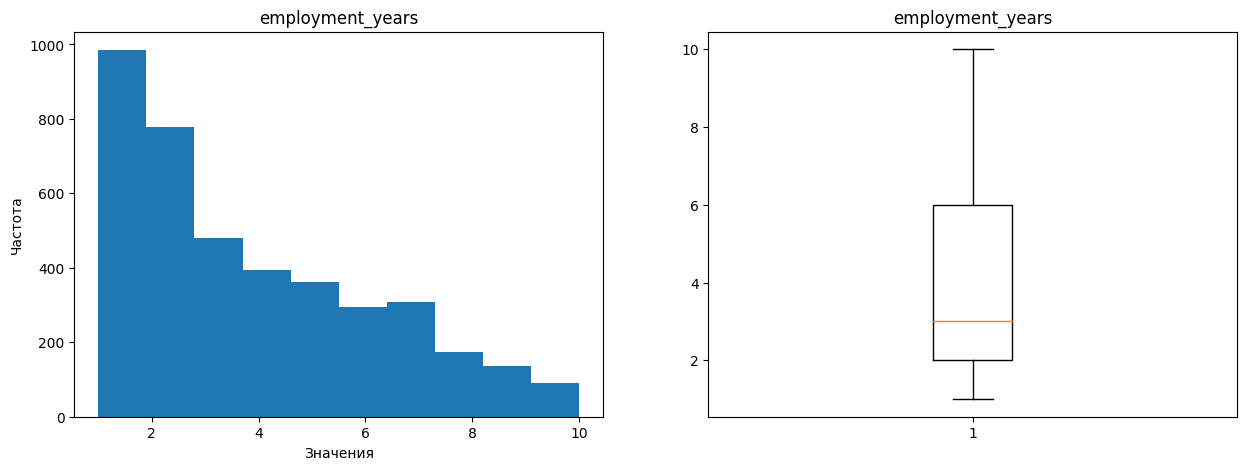

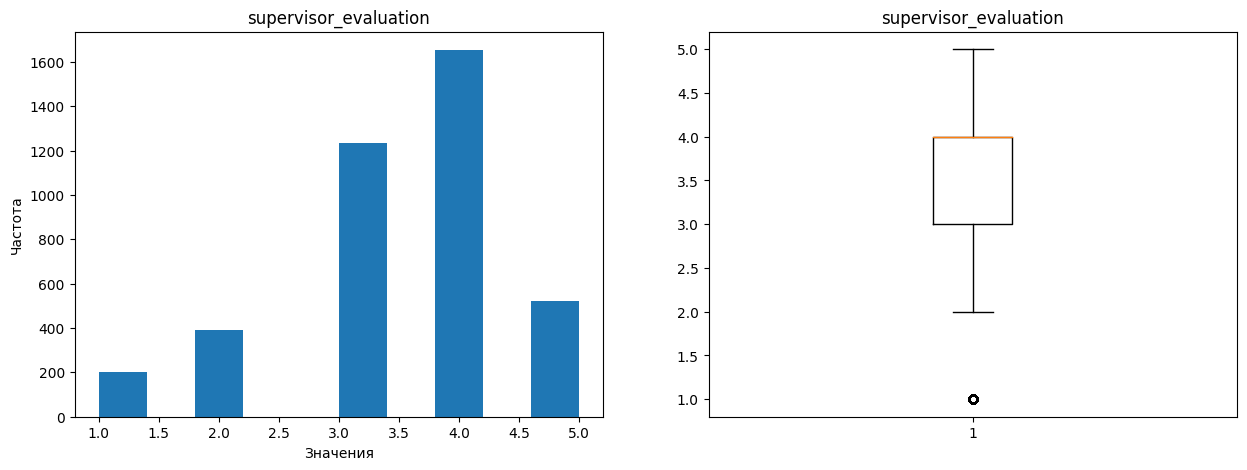

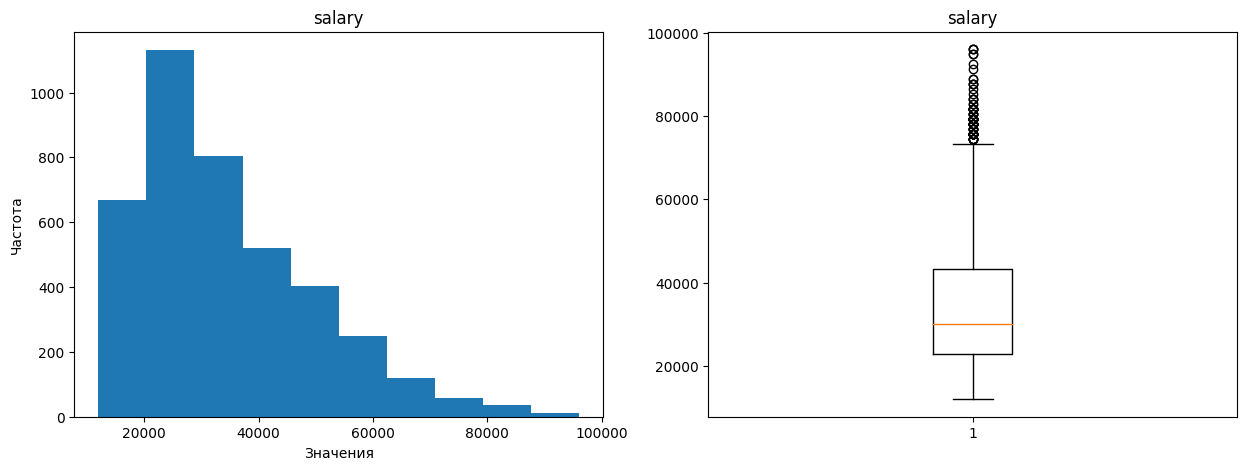

In [67]:
col=['employment_years', 'supervisor_evaluation', 'salary']
todoplot(train1)

***Вывод:*** Да, похоже данные те же. В новых колонках quit в тренировочной и тестовой выборках ошибок не обнаружено.

### 2.3 Исследовательский анализ данных

#### 2.3.1
Так как практически все данные мы уже исследовали раньше, посмотрим только распределение данных в новом целевом признаке.

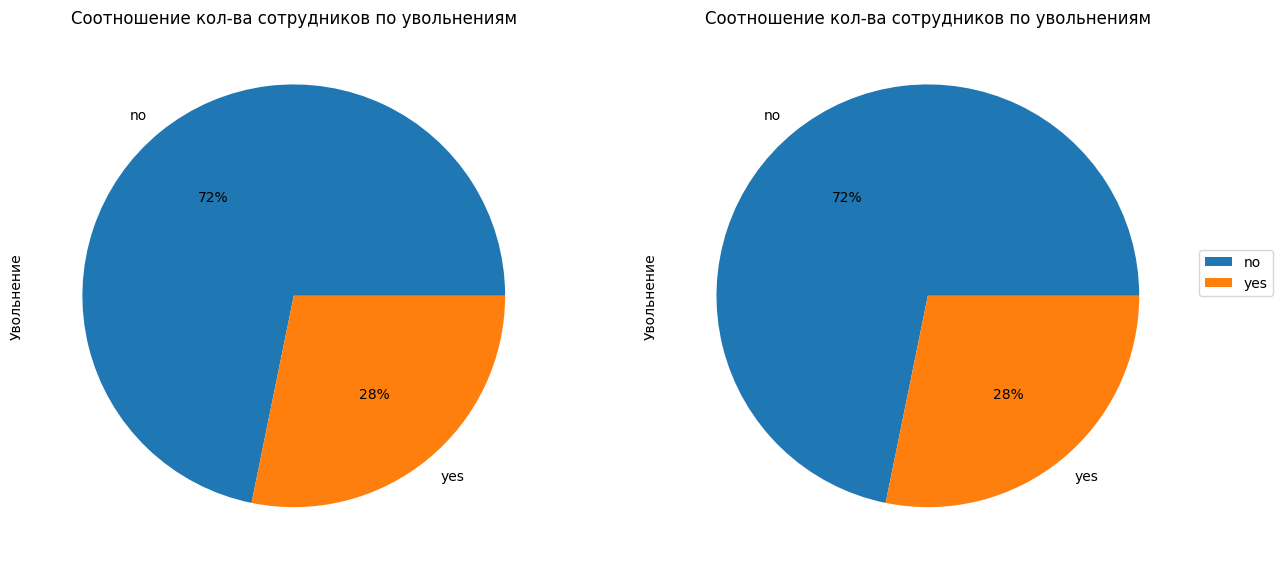

In [68]:
cols=['quit']
todopie(train1,y_test1,'Соотношение кол-ва сотрудников по увольнениям','Увольнение')

Видно, что уволенных сотрудников 28% от общего количества. В тренировочной и тестовой выборках число уволенных сотрудников примерно одинаковое.

#### 2.3.2
Попробуем составить портрет «уволившегося сотрудника».

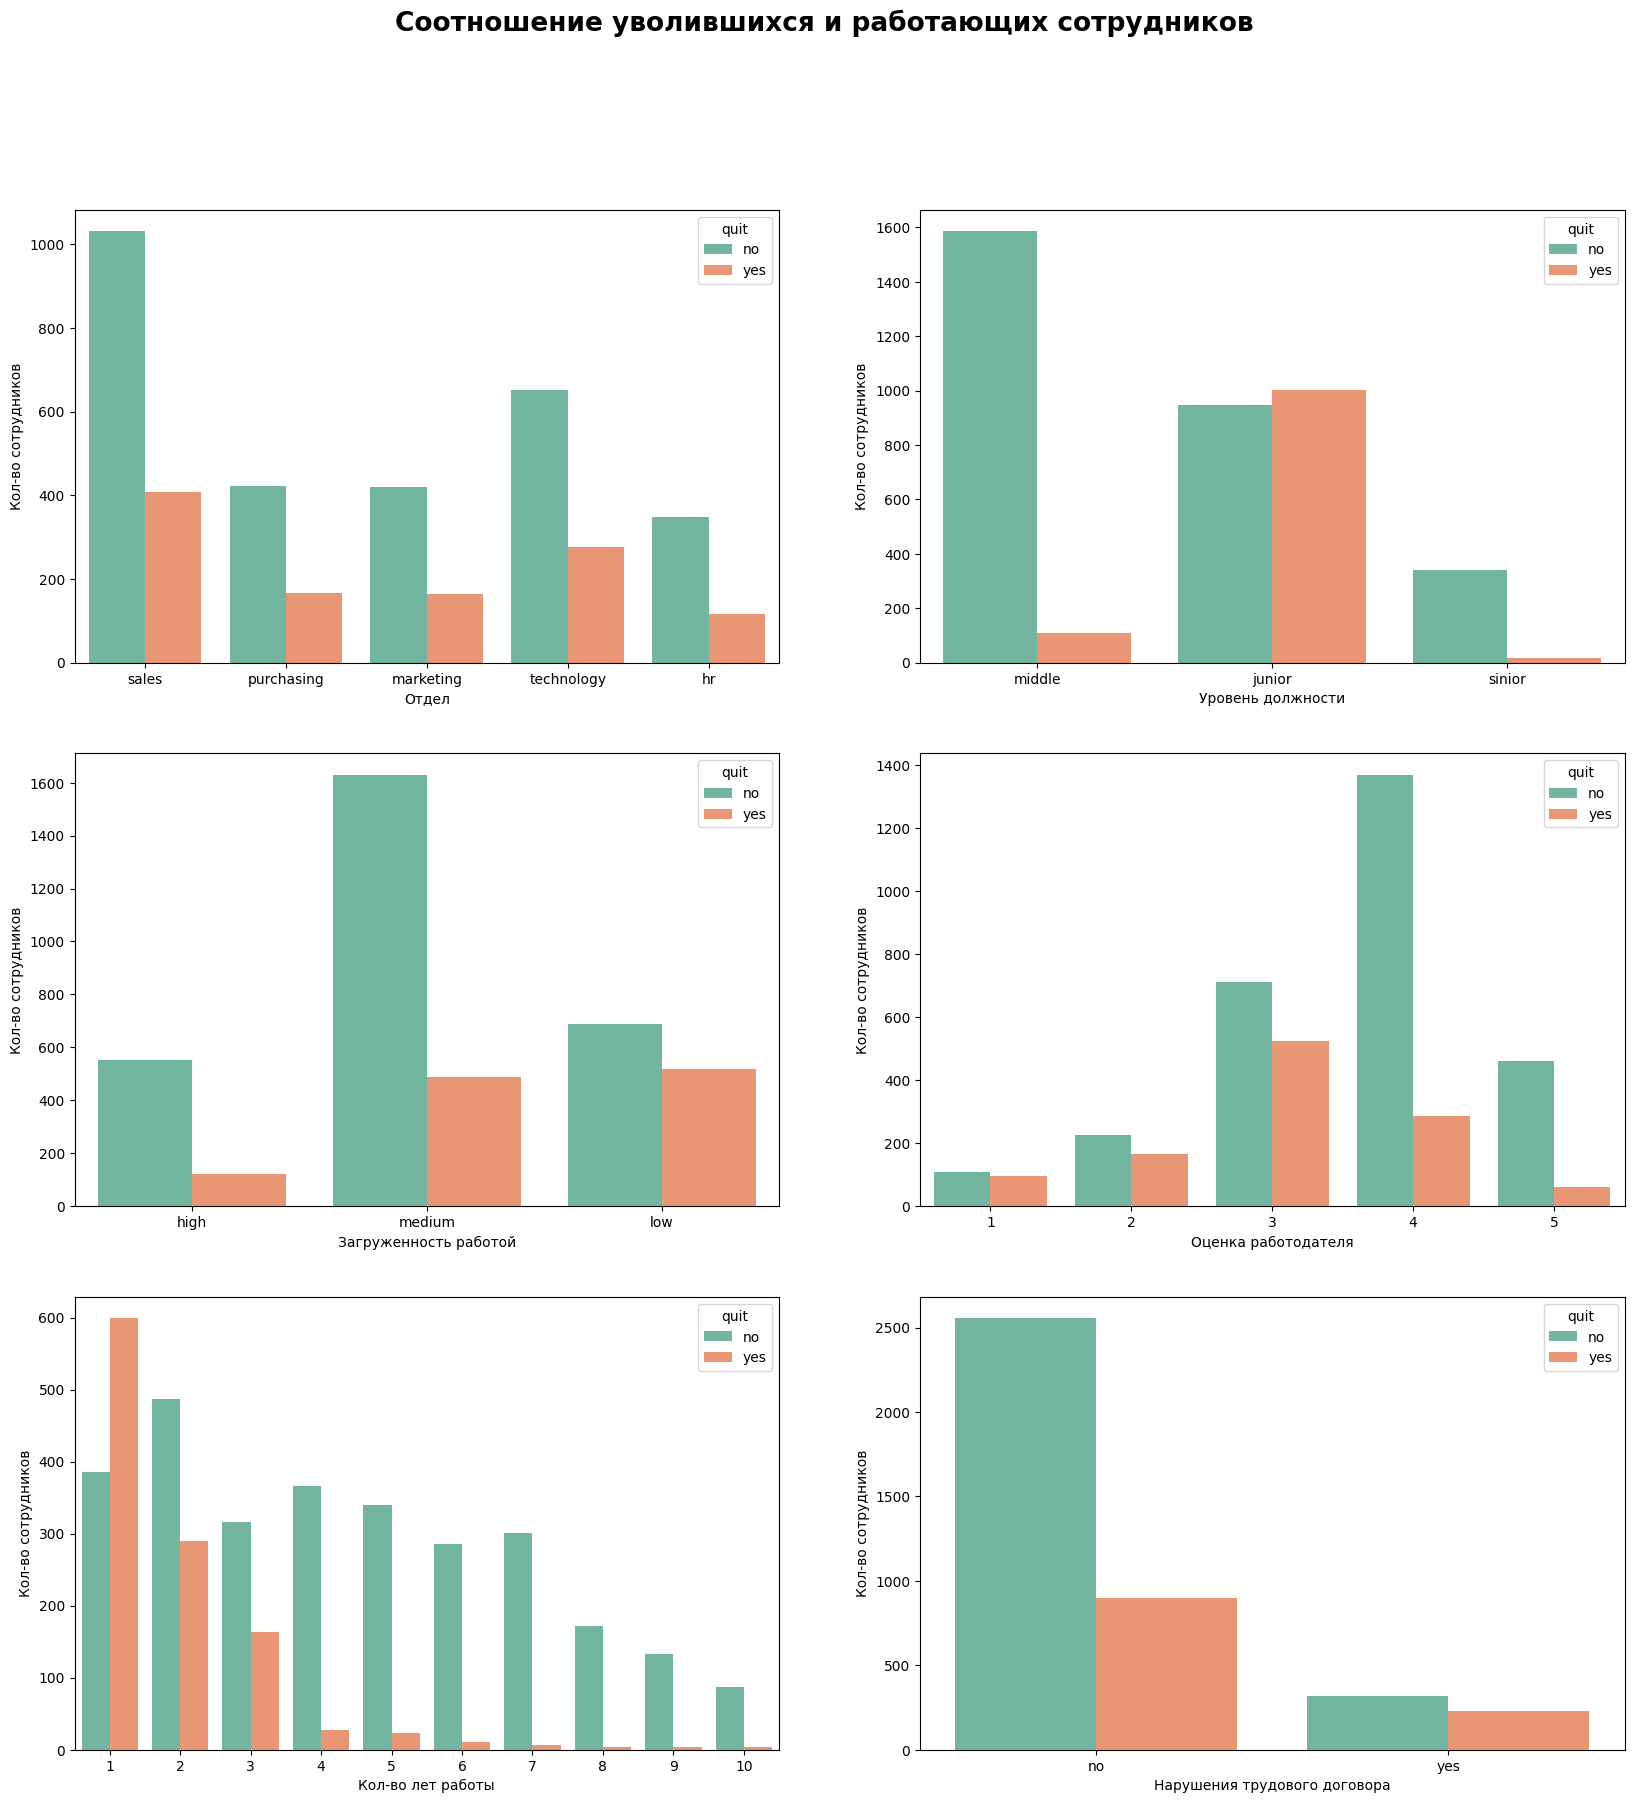

In [69]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')
sns.countplot(x ='dept', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[0,0]).set(xlabel='Отдел', ylabel='Кол-во сотрудников');
sns.countplot(x ='level', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Кол-во сотрудников');
sns.countplot(x ='workload', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[1,0]).set(xlabel='Загруженность работой', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[2,0]).set(xlabel='Кол-во лет работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_violations', data = train1, hue = 'quit',
              palette = "Set2", ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Кол-во сотрудников');

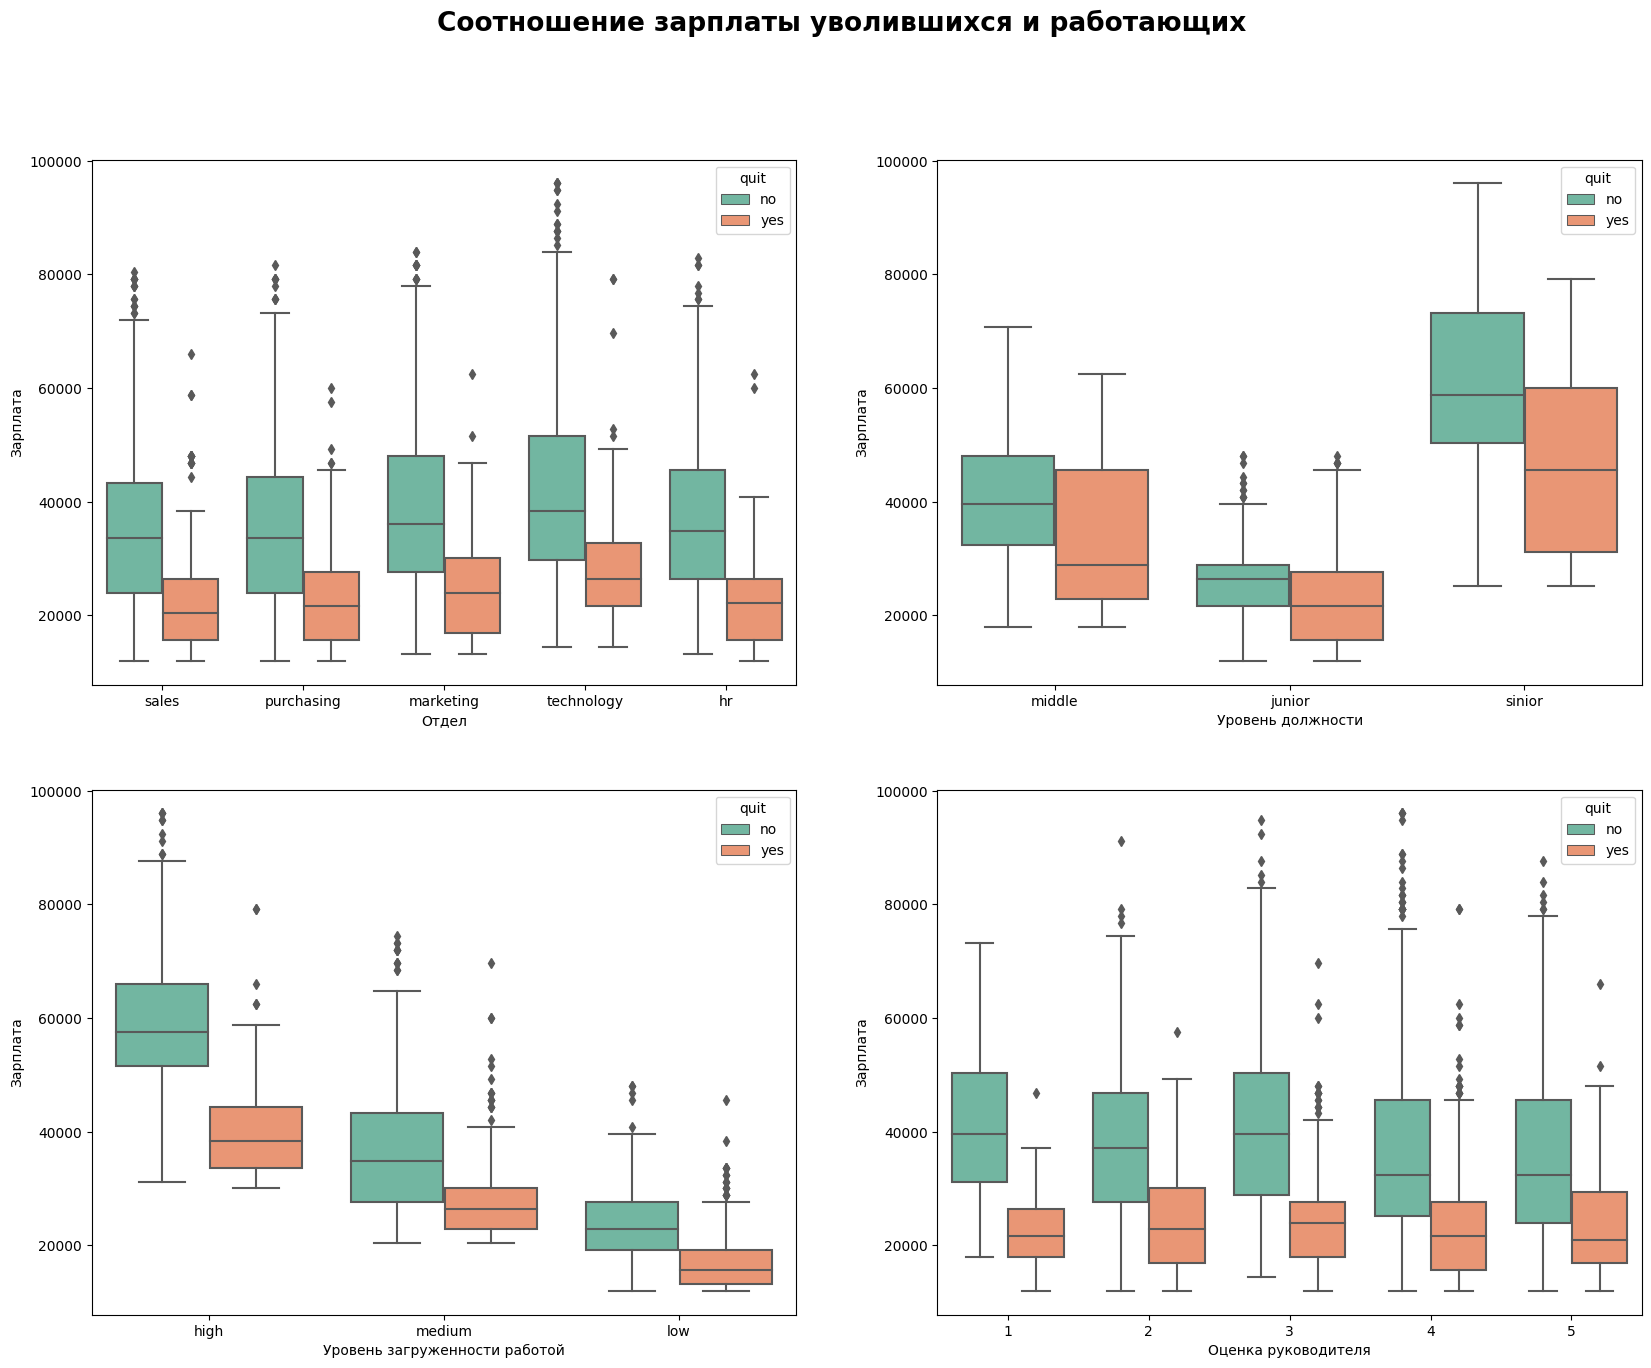

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
plt.suptitle('Соотношение зарплаты уволившихся и работающих', fontsize=19, fontweight='bold')
sns.boxplot(x='dept', y='salary', hue='quit', 
            palette='Set2', data=train1, ax=axes[0,0]).set(xlabel='Отдел', ylabel='Зарплата');
sns.boxplot(x='level', y='salary', hue='quit', 
            palette='Set2', data=train1, ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Зарплата');
sns.boxplot(x='workload', y='salary', hue='quit', 
            palette='Set2', data=train1, ax=axes[1,0]).set(xlabel='Уровень загруженности работой', ylabel='Зарплата');
sns.boxplot(x='supervisor_evaluation', y='salary', hue='quit', 
            palette='Set2', data=train1, ax=axes[1,1]).set(xlabel='Оценка руководителя', ylabel='Зарплата');

Анализируя графики, видно, что больше всего увольняются сотрудники с уровнем должности junior, с уровнем загруженности работой low, имеющие низкие оценки руководителя (от 1 до 3) и недавно работающие в компании. Отдел, в котором работает сотрудник, на увольнение не влияет. Кроме того, изучив средние зарплаты, мы видим, что средние зарплаты уволившихся сотрудников в сравнении с продолжающими работать ниже, причем во всех категориях (во всех отделах, во всех уровнях загруженности, во всех уровнях должности, со всеми оценками работодателя). Таким образом, типичный уволенный сотрудник - это недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой.

#### 2.3.3

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Нам нужно проверить, так ли это. Для этого добавим в тестовую выборку с целевым признаком Увольнение целевой признак из первой задачи (удовлетворенность работой) и проведем корреляцию между ними.

In [71]:
data1=y_test.merge(y_test1, on='id')

In [72]:
data1=data1.set_index('id')

In [73]:
interval_cols = ['job_satisfaction_rate']
phik_overview = phik_matrix(data1,interval_cols=interval_cols)

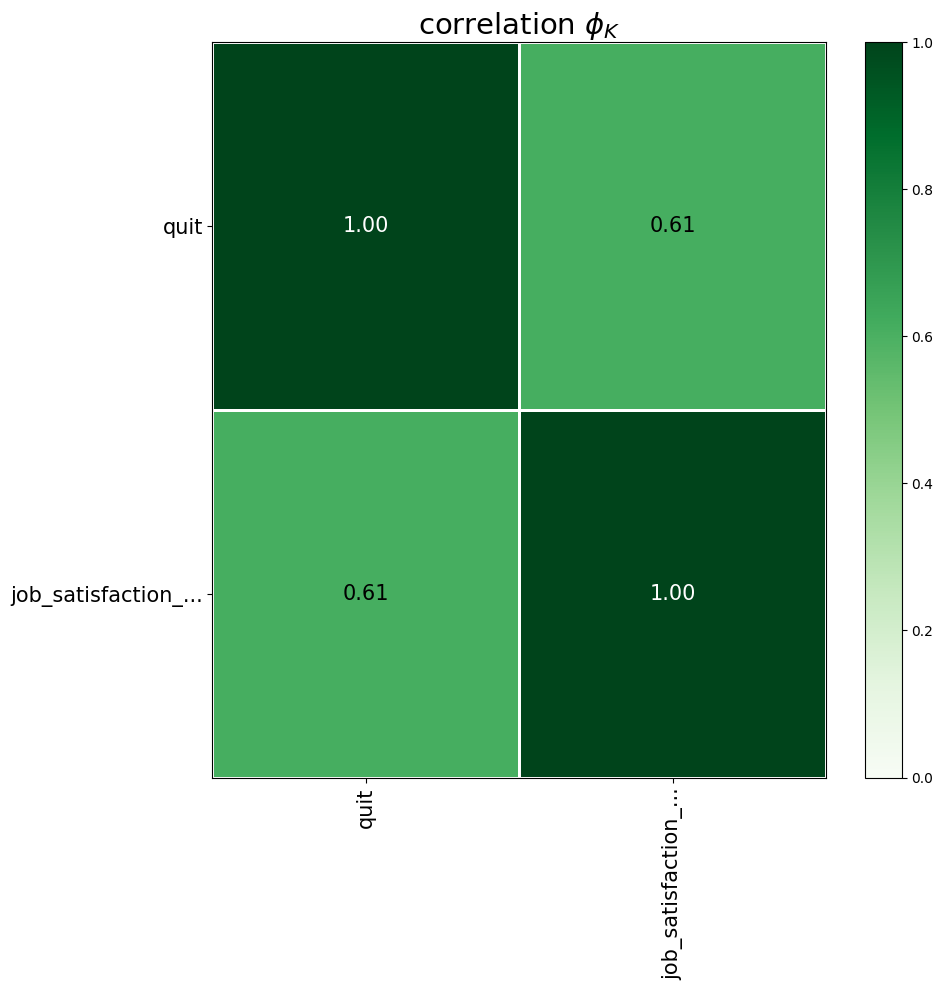

In [74]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

Видно, что удовлетворенность работой сильно влияет на целевой признак, а значит до обучения моделей нам нужно будет добавить этот признак в тренировочную и тестовую выборки.

***Вывод:*** Мы провели исследовательский анализ данных, посмотрели распределение нового признака Увольнение, составили портрет "типичного" увольняющегося сотрудника (недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой), кроме того нашли достаточно сильную корреляцию между удовлетворенностью работой и увольнением.

### 2.4 Добавление нового входного признака

Добавим признак удовлетворенности работой в наши выборки: тестовую и тренировочную. Для этого воспользуемся нашей лучшей моделью из первой задачи. Получим предсказания удовлетворенности и добавим в виде дополнительного столбца в тестовую и тренировочную выборки.

In [75]:
X_test1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(X_test)
X_test1.head()

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.837297
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826
2,467458,sales,middle,low,5,no,no,4,19200,0.664000
3,418655,sales,middle,low,6,no,no,4,19200,0.664000
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978


In [76]:
train1['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(train1.drop(['quit'], axis=1))
train1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.602105
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.837297
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.402143
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.813636


***Вывод:*** Мы добавили новый входной признак в тестовую и тренировочную выборки и готовы к подготовке данных для обучения моделей.

### 2.5 Подготовка данных

Подготовка данных будет проходить аналогично первой задаче, только к масштабированию количественных признаков добавится новый признак - удовлетворенность работой. Плюс надо не забыть, что целевой признак у нас теперь категориальный, а это значит его надо тоже кодировать - методом LabelEncoder.

In [77]:
train_temp1 = train1.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp1.duplicated().sum())

Количество дубликатов: 1413


In [78]:
train_temp1 = train_temp1.drop_duplicates().reset_index(drop=True)

In [79]:
X_train1 = train_temp1.drop(['quit'], axis=1)
y_train1 = train_temp1['quit']
X_train1.shape

(2587, 9)

In [80]:
test1 = X_test1.merge(y_test1, on='id')

In [81]:
X_test1_ = test1.drop(['quit','id'], axis=1)
y_test1_ = test1['quit']
X_test1_.shape

(2000, 9)

In [82]:
label_encoder = LabelEncoder()
y_train1 = label_encoder.fit_transform(y_train1)
y_test1_ = label_encoder.transform(y_test1_)

In [83]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [84]:
pipe(ohe_columns, ord_columns, num_columns)

***Вывод:*** На этом этапе мы провели подготовку данных (кодирование (в том числе целевого признака), масштабирование, обработка пропусков) с использованием пайплайна. И теперь мы готовы приступить к обучению моделей.

### 2.6 Обучение моделей

Целевой признак у нас один - Увольнение. Вариантов у него всего 2 - да или нет. А значит нам предстоит задача бинарной классификации. Для бинарной классификации нам подойдут модели логистической регрессии, метод опорных векторов, KNN и дерево решений (для всех используем перебор разных гиперпараметров).

Зададим параметры для обозначенных выше четырех моделей.

In [85]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(6, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

Запустим обучение перебором, используя метод RandomizedSearchCV для экономии ресурсов и для ускорения работы алгоритма. Для оценки качества моделей будем использовать метрику ROC_AUC, как самую универсальную и сбалансированную метрику, которая не зависит от порога классификации.

In [86]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train1, y_train1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [87]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [88]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058315,0.004265,0.019763,0.001032,MinMaxScaler(),2,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.919797,0.889683,0.893684,0.895194,0.912208,0.902113,0.011731,4
1,0.044741,0.002956,0.019777,0.002776,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,6,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.880849,0.908533,0.878090,0.903981,0.920516,0.898394,0.016392,10
2,0.045910,0.001662,0.041454,0.002303,MinMaxScaler(),NaN,KNeighborsClassifier(),NaN,NaN,4,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.867326,0.862633,0.875104,0.864496,0.876589,0.869230,0.005625,20
3,0.044962,0.002932,0.018995,0.002011,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",8,6,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.899974,0.904086,0.881047,0.884891,0.906581,0.895316,0.010371,11
4,0.047987,0.001912,0.020037,0.001142,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,5,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.888954,0.904521,0.904550,0.902273,0.928941,0.905848,0.012922,1
5,0.044717,0.003901,0.019832,0.001729,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,5,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.888954,0.904521,0.904550,0.902273,0.928941,0.905848,0.012922,1
6,0.194040,0.008388,0.059526,0.002763,StandardScaler(),NaN,SVC(random_state=42),NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.914675,0.891014,0.893763,0.889008,0.918183,0.901329,0.012471,7
7,0.067167,0.006897,0.019498,0.001440,StandardScaler(),1,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.919091,0.890034,0.892883,0.894230,0.912736,0.901795,0.011780,5
8,0.046493,0.005593,0.019210,0.001972,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",6,6,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.885225,0.882842,0.872177,0.907385,0.885678,0.886661,0.011462,17
9,0.044682,0.005794,0.017563,0.000951,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",6,4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.904243,0.883822,0.887810,0.879459,0.899202,0.890907,0.009354,15


Лучшей моделью оказалось дерево решений с максимальной глубиной 5 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 7. 

Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику ROC_AUC.

In [89]:
y_test_proba = randomized_search.predict_proba(X_test1_)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9076433750172859


Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


Результат метрики получился 0.908, то есть практически такой же, как на тренировочной выборке. Значит наша модель справляется хорошо, но недостаточно.

Проанализируем важность признаков для модели, чтобы понять, есть ли лишние признаки. Для этого воспользуемся модулем shap.

In [90]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train1)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test1_)

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros


PermutationExplainer explainer: 2001it [00:41, 41.95it/s]


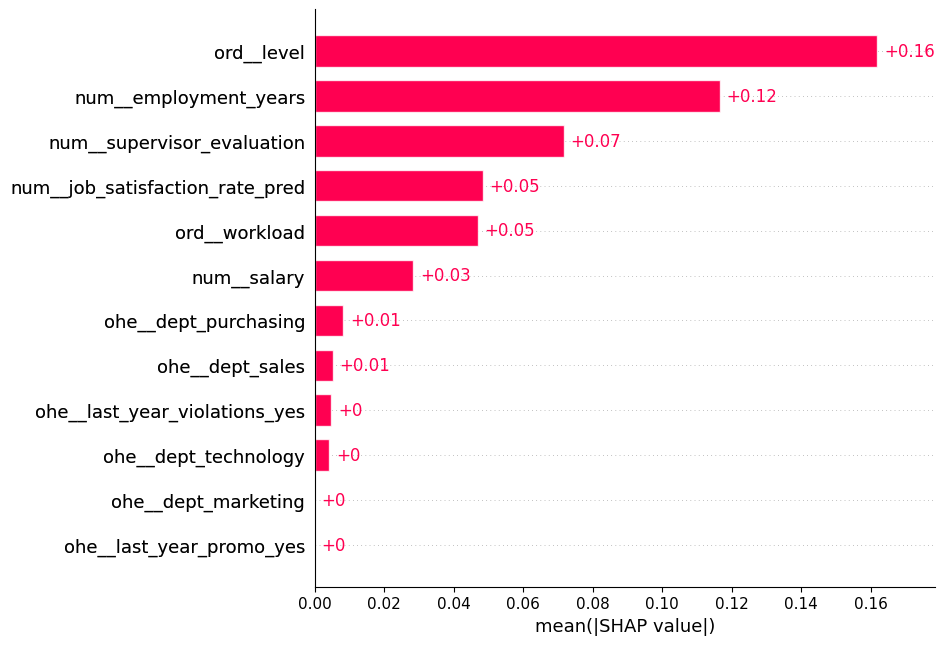

In [91]:
explainer = shap.PermutationExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_test_transformed)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
explainer.feature_names = feature_names
shap_values_ = explainer(X_test_transformed)
shap.plots.bar(shap_values_[:,:,1], max_display=16)

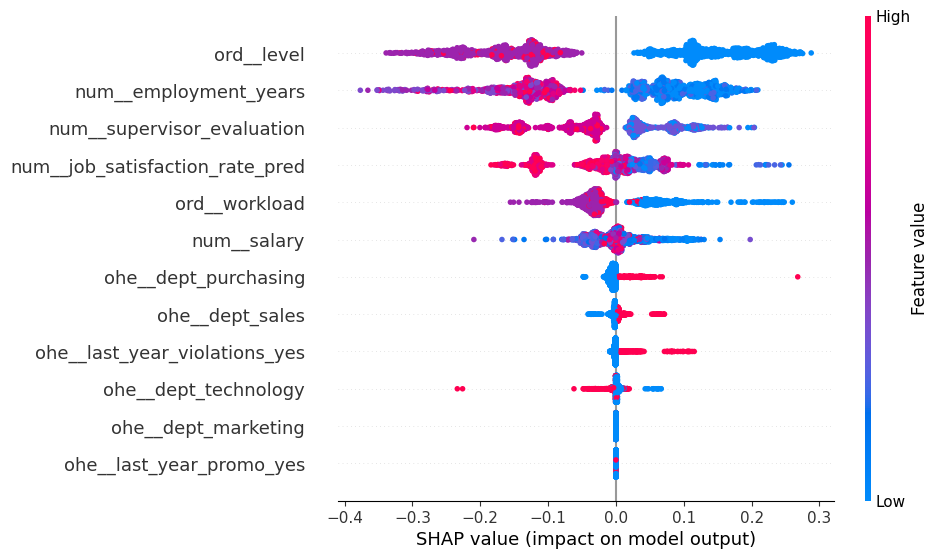

In [92]:
shap.plots.beeswarm(shap_values_[:,:,1], max_display=16) 

Мы видим, что для нашей модели наиболее важным оказался признак level, а вот признаки с повышением сотрудника, нарушением трудового договора и отделом похоже мало влияют на нашу модель. Попробуем убрать их и посмотрим, изменится ли результат метрики.

In [93]:
X_train2 = X_train1.drop(['dept','last_year_promo','last_year_violations'], axis=1)
X_test2 = X_test1_.drop(['dept'], axis=1)
X_train2.shape, X_test2.shape

((2587, 6), (2000, 8))

In [94]:
ohe_columns = [ 
    
    
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [95]:
pipe(ohe_columns, ord_columns, num_columns)

In [96]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train2, y_train1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='mo...
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [97]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                          

In [98]:
y_test_proba = randomized_search.predict_proba(X_test2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9177192605543372


Как мы видим, результат улучшился и теперь метрика составляет почти 0.92. Удалив ненужные признаки, мы не только увеличили метрику, но и уменьшили время на работу алгоритма по поиску параметров. Это бывает очень важно, когда требуется, чтобы модель часто пересчитывала коэффициенты при поступлении новых данных в реальном времени.

### 2.7 Выводы

Мы завершили работу над второй задачей и обучили модель предсказывать, уволится сотрудник из компании или нет. Лучшей моделью для этой задачи оказалось дерево решений (точность предсказаний около 91%).
Вероятно дерево решений справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров.

## Общие выводы

Мы провели большую работу по разработка модели по уменьшению оттока сотрудников крупной компании "Х". 

Сначала выполнили первую поставленную перед нами задачу: построили модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

На пути к выполнению этой задачи мы провели следующую работу:
1. Провели загрузку данных и получили общаю информацию, которая показала, что в тренировочной выборке имеется 4000 строк, есть пропущенные значения в колонках с отделом и занимаемой должностью, дублей нет, все форматы данных соответствуют данным. В тестовой выборке с входными данными имеется 2000 строк, так же есть пропущенные значения в колонках с отделом и занимаемой должностью, дублей нет, все форматы данных соответствуют данным. В тестовый выборке с целевым признаком строк так же 2000, дублей нет, пропусков нет, форматы данных соответствуют данным.
2. Провели предобработку данных. На этом этапе мы проверили данные на ошибки в категориальных признаках. Нашли пустые значения в двух колонках тестовой выборки и заменили их на NaN. Проверили количественных данные на достоверность и не нашли отрицательных и аномальных значений.
3. Провели исследовательский анализ данных, посмотрели распределение данных во всех таблицах, по итогам анализа можно сказать, что данные выглядят достоверно, особых выбросов нет, при проведении корреляционного анализа утечки целевого признака не обнаружено.
4. Провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна.
5. Так как целевой признак у нас непрерывный количественный, то для для обучения мы взяли две модели регрессии: модель линейной регрессии и дерево решений (для дерева решений использовали перебор разных гиперпараметров). Провели обучение моделей, выбрали лучшую на основе метрики SMAPE. Лучшей моделью получилась модель дерево решений с максимальной глубиной - 10, максимальным число признаков, по которым ищется лучшее разбиение в дереве - 10. После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.

Затем мы выполнили вторую задачу: построили модель, которая может предсказать, уволится сотрудник из компании или нет. Для этого мы проделали следующую работу:
1. Провели загрузку новых данных. В новых датасетах пропусков и дублей нет. В тренировочной выборке всё так же 4000 строк, в тестовой 2000.
2. Провели предобработку данных. В новых колонках quit в тренировочной и тестовой выборках ошибок не обнаружено. Данные распределены так же, как в первой задаче.
3. Провели исследовательский анализ данных, посмотрели распределение нового признака Увольнение, составили портрет "типичного" увольняющегося сотрудника (недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой), кроме того нашли достаточно сильную корреляцию между удовлетворенностью работой и увольнением.
4. Мы добавили новый входной признак (удовлетворенность работой) в тестовую и тренировочную выборки.
5. Провели подготовку данных (кодирование, масштабирование, обработка пропусков) с использованием пайплайна.
6. Целевой признак у нас один - Увольнение. Вариантов у него всего 2 - да или нет. А значит это задача бинарной классификации. Для бинарной классификации мы использовали модели логистической регрессии, метод опорных векторов, KNN и дерево решений (для всех использовали перебор разных гиперпараметров). Провели обучение моделей, выбрали лучшую на основе метрики ROC_AUC. Лучшей моделью для этой задачи оказалось дерево решений с максимальной глубиной 5 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 7 (точность предсказаний около 91%). После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо.
Затем мы проанализировали важность признаков для модели. Убрали неважные признаки (повышение сотрудников, отдел, нарушение трудового договора). Результат метрики улучшился и составил почти 0.92. Удалив ненужные признаки, мы не только увеличили метрику, но и уменьшили время на работу алгоритма по поиску параметров. Это бывает очень важно, когда требуется, чтобы модель часто пересчитывала коэффициенты при поступлении новых данных в реальном времени..

Среди пожеланий заказчику можно отметить, что для того, чтобы сотрудники меньше увольнялись, нужно следить за их удовлетворенностью работой, быстрее переводить из разряда junior в разряд medium, больше загружать работой (соответственно будет выше зарплата). 